
#  📱Telecom Churn Dataset  
---
**프로젝트**: Orange Telecom 고객 행동예측(이탈 원인) 및 고객 데이터 분석   (제출자 : 신정아)

## 📌 분석 개요 및 목적
본 리포트는 Orange Telecom의 고객 데이터 분석을 통하여, 고객 이탈을 예측하며, 실제 통신업계 현장에서 선제적인 의사결정을 지원할 수 있는 **'설명 가능하고 신뢰할 수 있는 분석'** 을 구축하는 과정을 담았습니다.

### 🔍 분석 파이프라인
1.  **Deep EDA & Statistical Testing**:
    문제 정의 및 데이터 이해, 데이터 전처리
2.  **Advanced Preprocessing (VIF Verification)**:
    *   다중공선성(Multicollinearity)은 회귀분석의 결과값을 불안정하게 합니다. 상관계수 기반 제거뿐만 아니라, **VIF(분산 팽창 요인) 사후 검증** 을 통해 변수의 독립성을 수학적으로 보장합니다.
3.  **Decision Boundary Visualization**:
    *   PCA를 통해 고차원 데이터를 2차원으로 축소하여, 모델의 선형 분리 성능을 시각적으로 확인합니다.
4.  **Modeling**:
    *   **Logistic Regression**: 보고서 작성에 있어 인과관계/통계적 근거로 설명합니다.
    *   **Random Forest**: 모든 변수를 스케일링하여, 변수 간 영향력을 공정하게 비교합니다.
5.  **모델 평가 및 해석**
6.  **비지니스 인사이트 도출**

In [275]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats 
from scipy.cluster import hierarchy
from scipy.stats import chi2_contingency

# Scikit-learn
from sklearn.model_selection import train_test_split,RandomizedSearchCV, StratifiedKFold, GridSearchCV, learning_curve, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_is_fitted
from sklearn.decomposition import PCA 
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import (classification_report, roc_curve, roc_auc_score, auc, average_precision_score,
                             precision_recall_curve, confusion_matrix, f1_score, brier_score_loss)
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100

print("✅ All libraries loaded successfully!")

✅ All libraries loaded successfully!


## 1. 데이터 로드 및 구조 파악
가장 먼저 이탈자(Churn)의 분포를 확인해야 합니다. 

###
**Churn 정의**:   
    - 원본: True, False  
    - **변경**: 1(True/이탈), 0(False/유지)  

**결과 해석**:
데이터 로드 후 기본적으로 가입 유지/이탈을 구분하는 Churn 컬럼을 확인하여, 가입자 중 전체 평균 이탈률이 14.55% 인 것을 확인하였습니다. 


In [4]:
data80 = pd.read_csv('./churn-bigml-80.csv')
data20 = pd.read_csv('./churn-bigml-20.csv')

In [ ]:
print(data80.shape)
data80.info()

(2666, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 

In [6]:
data80['Churn_num'] = data80['Churn'].astype(int)
data80.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
State,2666,51,WV,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Account length,2666.0,NaN,NaN,NaN,100.620405,39.563974,1.0,73.0,100.0,127.0,243.0
Area code,2666.0,NaN,NaN,NaN,437.43886,42.521018,408.0,408.0,415.0,510.0,510.0
International plan,2666,2,No,2396,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Voice mail plan,2666,2,No,1933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number vmail messages,2666.0,NaN,NaN,NaN,8.021755,13.612277,0.0,0.0,0.0,19.0,50.0
Total day minutes,2666.0,NaN,NaN,NaN,179.48162,54.21035,0.0,143.4,179.95,215.9,350.8
Total day calls,2666.0,NaN,NaN,NaN,100.310203,19.988162,0.0,87.0,101.0,114.0,160.0
Total day charge,2666.0,NaN,NaN,NaN,30.512404,9.215733,0.0,24.38,30.59,36.7,59.64
Total eve minutes,2666.0,NaN,NaN,NaN,200.386159,50.951515,0.0,165.3,200.9,235.1,363.7


=== Churn Distribution ===
Churn
False    0.854464
True     0.145536
Name: proportion, dtype: float64


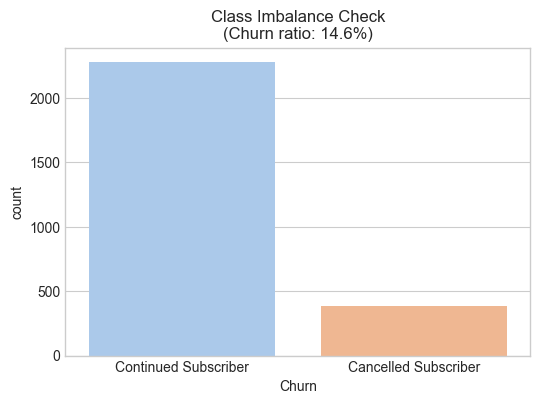

In [147]:
# 클래스 불균형 비율 계산
churn_counts = data80['Churn'].value_counts(normalize=True)
print("=== Churn Distribution ===")
print(churn_counts)

# 시각화
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=data80, palette='pastel')
plt.title(f'Class Imbalance Check\n(Churn ratio: {churn_counts[1]*100:.1f}%)')
plt.xticks([0, 1], ['Continued Subscriber', 'Cancelled Subscriber'])
plt.show()

####

### **1-1. 데이터 구조**
- 컬럼 개수: 20
- 총 데이터 수: 2666
- 결측치 여부: X
- 실수형 데이터 및 범주형 결과 예측  

**💡Telecom Churn Dataset 특징**:
- **요금 관련 특징** 
1. International plan : 가입유무 (Yes/No) _ 가입유무와 상관없이 국제통화 발생내역 확인
2. Voice mail plan : 가입유무 (Yes/No) + Number vmail messages (개수)
3. day/eve/night/intl : 각 통화시간(minutes), 통화량(calls), 요금(charges)항목으로 구분 
=> 통화시간(minutes)와 요금(charges)는 상관계수가 '1'로 통화시간으로 데이터 분석 진행  

- **고객불만 반영 변수** 
: Customer service calls  

- **기타**
1. State (지역) : 어느 특정 지역 이탈자가 유의미하게 많은 경우, 지역 서비스 수준에 대한 검토 필요
2. Account length (가입기간) : 가입기간별 이탈률에 대한 검토 가능
3. Area code(지역코드)

**💡Churn**:
- **0**: False (유지, Continue Subscriber)
- **1**: True (이탈, Cancel Subscriber)

In [120]:
data80.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

### **1-2. Deep EDA (탐색적 데이터 분석)**

#### **1) 수치형 변수 확인**:
  
**분석 방법** 
- 수치형 컬럼의 각각 분포를 시각화하고, Skewness(왜도)와 이상치를 확인합니다.  

**분석 이유**
- **Skewness > 1 또는 < -1**: 분포가 심하게 치우쳐 있음 → 로그 변환 고려
- 랜덤포레스트는 비선형 모델이라 정규성이 필수는 아니지만, 극단적 왜곡은 리프 노드의 평균값을 왜곡시킬 수 있습니다.

In [121]:
# 수치형 변수확인
num_cols = data80.select_dtypes(include='number').columns
num_cols
data80.groupby('Churn')[num_cols].mean().T.sort_values(by=True, ascending=False)

Churn,False,True
Area code,437.420983,437.543814
Total eve minutes,198.853380,209.385309
Total night minutes,200.464091,205.307216
Total day minutes,175.104346,205.181186
Account length,100.330992,102.319588
Total day calls,100.159350,101.195876
Total night calls,100.007902,100.682990
Total eve calls,100.036435,99.948454
Total day charge,29.768266,34.881340
Total eve charge,16.902809,17.797861


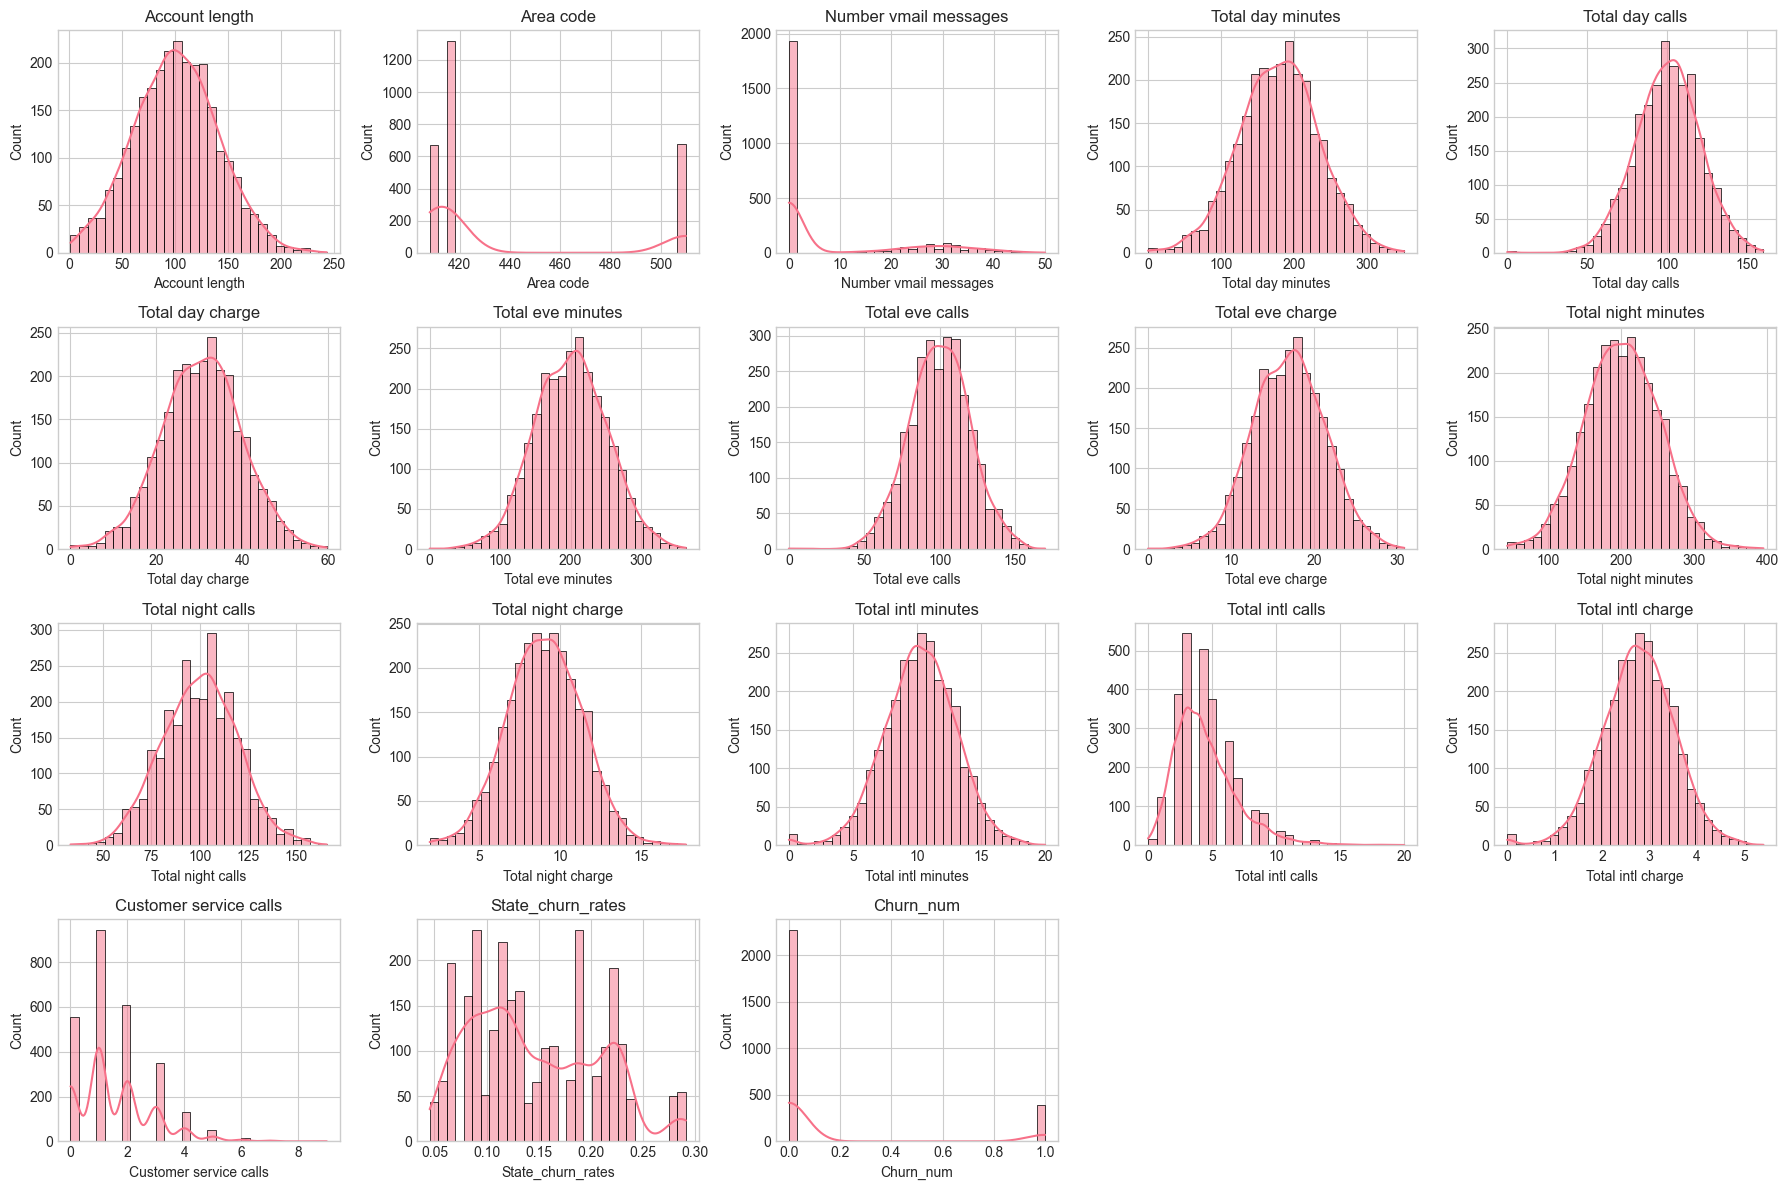

In [71]:
# 수치형 변수의 분포 분석
num_cols = data80.select_dtypes(include='number').columns

plt.figure(figsize=(18, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 5, i)  # (행, 열, 위치) -> 컬럼 수에 맞게 조절
    sns.histplot(data80[col], bins=30, kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

In [72]:
# Skewness 요약
skewness = data80.select_dtypes(include='number').skew()

skew_df = skewness.to_frame(name='skewness')
skew_df['abs_skew'] = skew_df['skewness'].abs() # 절대값 표기

print("\n📊 Skewness Summary:")
display(skew_df.sort_values('abs_skew', ascending=False))


📊 Skewness Summary:


,skewness,abs_skew
Churn_num,2.011470,2.011470
Total intl calls,1.358769,1.358769
Number vmail messages,1.271774,1.271774
Area code,1.110965,1.110965
Customer service calls,1.095176,1.095176
State_churn_rates,0.428533,0.428533
Total intl charge,-0.224569,0.224569
Total intl minutes,-0.224434,0.224434
Total day calls,-0.128267,0.128267
Account length,0.079023,0.079023


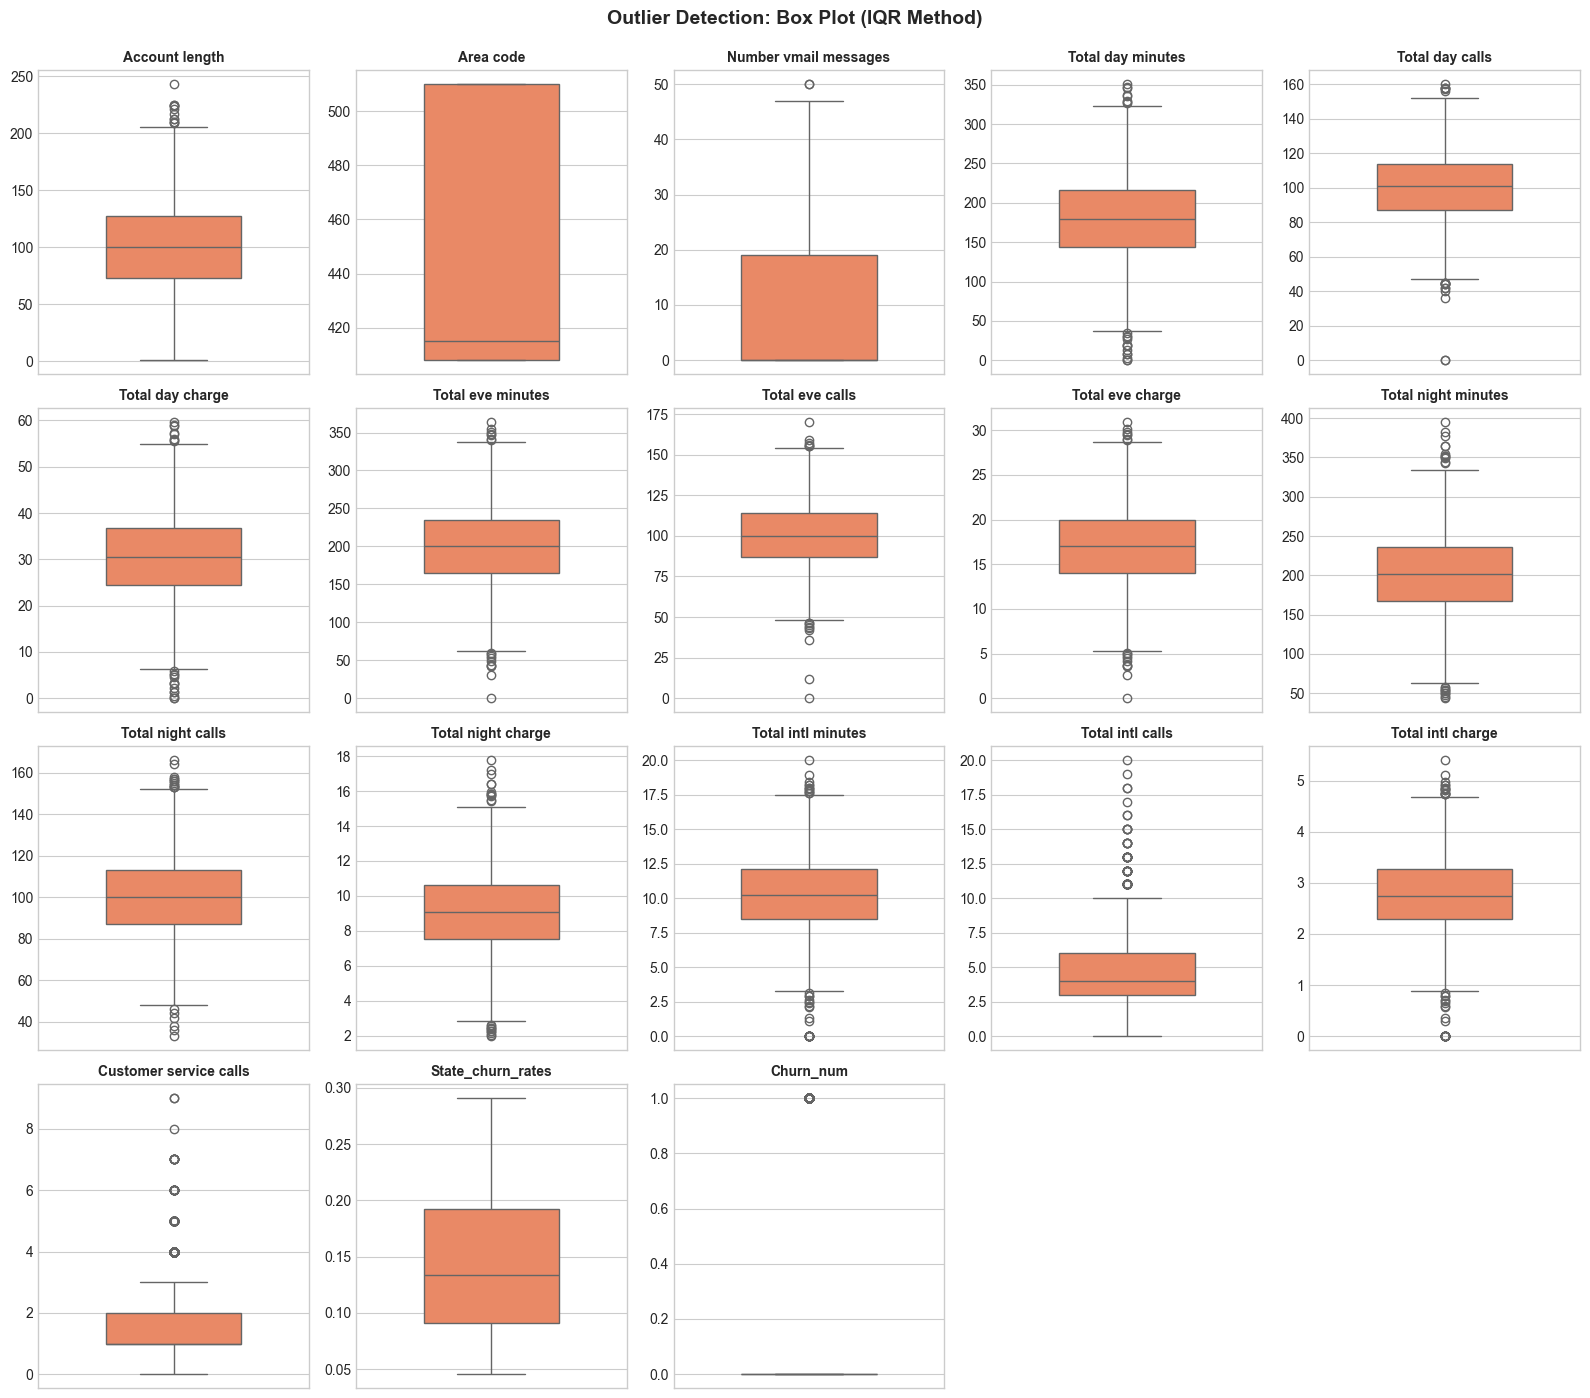


📊 Outlier Summary (IQR Method):


,Feature,Outlier_Count,Outlier_Ratio(%)
17,Churn_num,388,14.55
15,Customer service calls,210,7.88
13,Total intl calls,66,2.48
14,Total intl charge,40,1.50
12,Total intl minutes,37,1.39
11,Total night charge,22,0.83
9,Total night minutes,22,0.83
5,Total day charge,21,0.79
3,Total day minutes,21,0.79
10,Total night calls,19,0.71



💡 [Decision]
- 이상치 비율이 모두 10% 미만이므로, Random Forest의 강건성(Robustness)을 활용하여 제거하지 않습니다.
- 필요 시 Winsorization(99% percentile로 capping) 적용 가능


In [150]:
# 이상치 탐지
fig, axes = plt.subplots(4, 5, figsize=(16, 14))
axes = axes.ravel()

outlier_summary = []

for i, col in enumerate(num_cols):
    ax = axes[i]
    sns.boxplot(y=data80[col], ax=ax, color='coral', width=0.5)
    ax.set_title(f'{col}', fontsize=10, fontweight='bold')
    ax.set_ylabel('')

    # IQR 기반 이상치 계산
    Q1 = data80[col].quantile(0.25)
    Q3 = data80[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = data80[(data80[col] < lower) | (data80[col] > upper)]
    outlier_count = len(outliers)
    outlier_ratio = outlier_count / len(data80) * 100

    outlier_summary.append({
        'Feature': col,
        'Outlier_Count': outlier_count,
        'Outlier_Ratio(%)': round(outlier_ratio, 2)
    })

# 빈 subplot 제거
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Outlier Detection: Box Plot (IQR Method)', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# 이상치 요약
outlier_data80 = pd.DataFrame(outlier_summary).sort_values('Outlier_Count', ascending=False)
print("\n📊 Outlier Summary (IQR Method):")
display(outlier_data80)

print("\n💡 [Decision]")
print(f"- 이상치 비율이 모두 10% 미만이므로, Random Forest의 강건성(Robustness)을 활용하여 제거하지 않습니다.")
print(f"- 필요 시 Winsorization(99% percentile로 capping) 적용 가능")


#### **2) 범주형 변수 확인**:
  
**분석 방법**   
- 범주형 데이터를 구분하고, 해당 범주별 이탈률을 계산합니다.
    
**분석 이유**  
- 전체 데이터에 있어서의 이탈률 평균과 각 범주에서 나타나는 이탈률을 비교하여, 해당 데이터의 특성을 파악합니다.  

**분석 결과**  
- **State** : 각 State별 이탈률을 계산하여 해당 지역의 서비스제공에 차이여부를 추정해볼 수 있다. 
- **International plan, Voice mail plan** : 요금제 가입여부와 고객 이탈률의 상관관계에 대하여 확인해 볼 수 있다.  

In [149]:
# 범주형 데이터 - 지역 및 요금제에 따른 이탈률 확인
cat_cols = data80.select_dtypes(include='object').columns

for col in cat_cols:
    print(f"\n📌 {col} (Churn 기준 개수/비율)")
    
    ct = pd.crosstab(data80[col], data80['Churn'])
    rate = pd.crosstab(data80[col], data80['Churn'], normalize='index') * 100
    
    result = ct.join(rate, lsuffix='_count', rsuffix='_rate(%)')
    display(result)


📌 State (Churn 기준 개수/비율)


Churn,False_count,True_count,False_rate(%),True_rate(%)
State,,,,
AK,40,3,93.023256,6.976744
AL,59,7,89.393939,10.606061
AR,36,11,76.595745,23.404255
AZ,42,3,93.333333,6.666667
CA,19,5,79.166667,20.833333
CO,52,7,88.135593,11.864407
CT,48,11,81.355932,18.644068
DC,40,5,88.888889,11.111111
DE,43,8,84.313725,15.686275



📌 International plan (Churn 기준 개수/비율)


Churn,False_count,True_count,False_rate(%),True_rate(%)
International plan,,,,
No,2126,270,88.731219,11.268781
Yes,152,118,56.296296,43.703704



📌 Voice mail plan (Churn 기준 개수/비율)


Churn,False_count,True_count,False_rate(%),True_rate(%)
Voice mail plan,,,,
No,1610,323,83.290222,16.709778
Yes,668,65,91.132333,8.867667


In [55]:
# 전체 평균 이탈률과 이탈률 Top10 지역
overall_churn_rate = data80['Churn'].mean() * 100
state_churn_rate = pd.crosstab(data80['State'], data80['Churn'], normalize='index') * 100
print('📌전체 지역 평균 이탈률(%):', round(overall_churn_rate,2))
print('📌State별 이탈률 (Top 10)')
state_churn_rate.sort_values(True, ascending=False).head(10)

📌전체 지역 평균 이탈률(%): 14.55
📌State별 이탈률 (Top 10)


Churn,False,True
State,,
TX,70.909091,29.090909
NJ,72.000000,28.000000
AR,76.595745,23.404255
MD,76.666667,23.333333
MS,77.083333,22.916667
SC,77.551020,22.448980
ME,77.551020,22.448980
MI,77.586207,22.413793
PA,77.777778,22.222222


In [49]:
# 지역별 이탈률 열추가 : Feature Engineering 2-1-4 항목 근거
state_churn_rates = data80.groupby('State')['Churn'].mean()
data80['State_churn_rates'] = data80['State'].map(state_churn_rates)
data80[['State', 'Churn', 'State_churn_rates']].head()

data80.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
State,2666,51,WV,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Account length,2666.0,NaN,NaN,NaN,100.620405,39.563974,1.0,73.0,100.0,127.0,243.0
Area code,2666.0,NaN,NaN,NaN,437.43886,42.521018,408.0,408.0,415.0,510.0,510.0
International plan,2666,2,No,2396,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Voice mail plan,2666,2,No,1933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number vmail messages,2666.0,NaN,NaN,NaN,8.021755,13.612277,0.0,0.0,0.0,19.0,50.0
Total day minutes,2666.0,NaN,NaN,NaN,179.48162,54.21035,0.0,143.4,179.95,215.9,350.8
Total day calls,2666.0,NaN,NaN,NaN,100.310203,19.988162,0.0,87.0,101.0,114.0,160.0
Total day charge,2666.0,NaN,NaN,NaN,30.512404,9.215733,0.0,24.38,30.59,36.7,59.64
Total eve minutes,2666.0,NaN,NaN,NaN,200.386159,50.951515,0.0,165.3,200.9,235.1,363.7


#### **3) 상관관계 분석**:  

**분석 방법**   
- **Heatmap**: 변수 간 Pearson 상관계수를 색상으로 시각화 (상삼각 마스킹으로 깔끔하게)  
- **High Correlation Pairs**: |r| > 0.7인 변수 쌍을 자동 탐지    
- **Hierarchical Clustering**: 변수들을 유사도 기반으로 군집화하여 Dendrogram으로 시각화  

**분석 이유**  
- **다중공선성(Multicollinearity)** 위험 탐지: 두 변수가 강하게 상관되어 있으면 하나는 제거 고려  
- 랜덤포레스트는 선형회귀와 달리 다중공선성에 덜 민감하지만, 해석 가능성(Interpretability)을 위해 확인 필요  
- Dendrogram은 "어떤 변수들이 비슷한 정보를 담고 있는가?"를 직관적으로 표현  

**결과 해석**:  
- 통신요금과 관련된 변수 중 minutes 항목은 charge와 상관계수가 1로 두 변수가 강하게 상관되어 있어 charge로 표시된 변수는 제거하는 것을 고려한다.

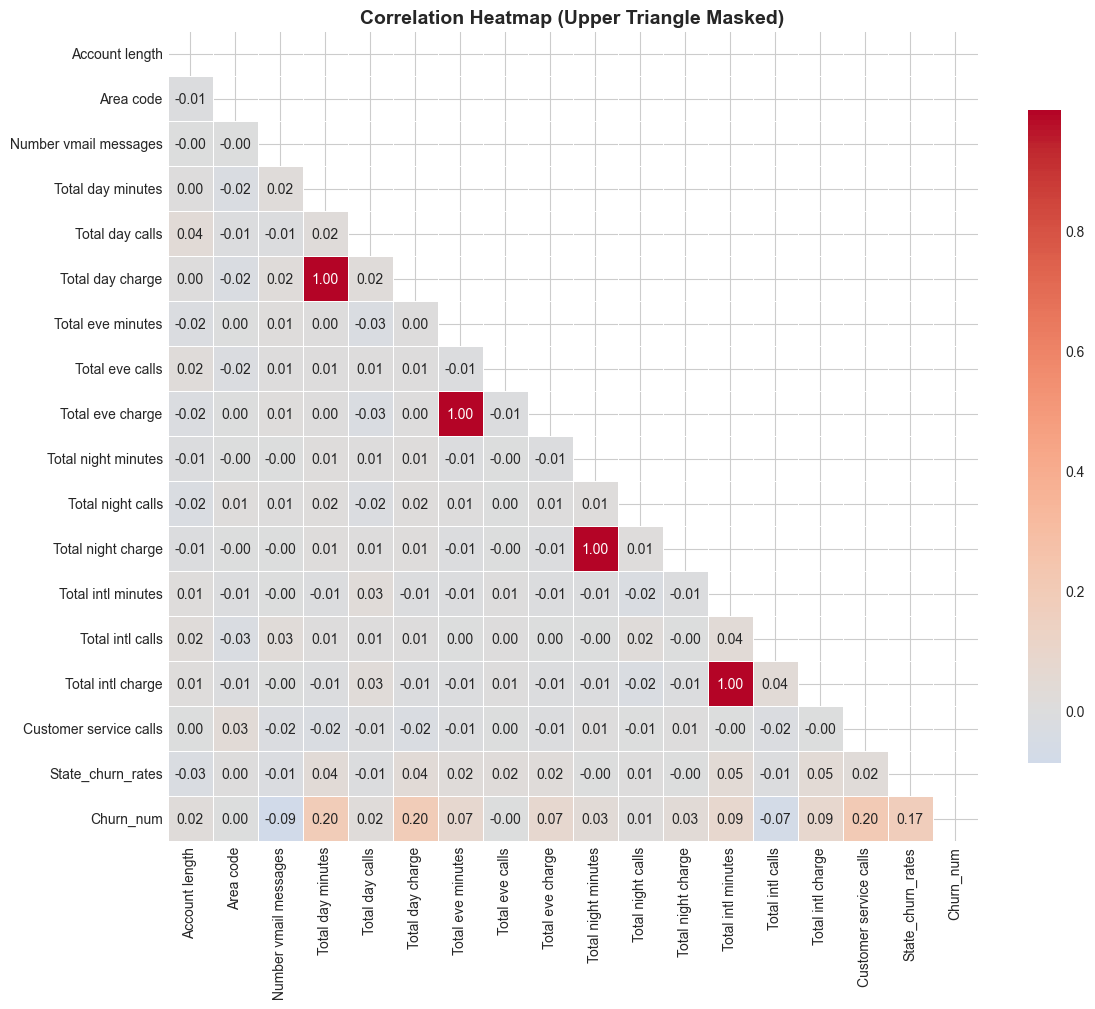


⚠️ High Correlation Pairs (|r| > 0.7):


,Var1,Var2,Correlation
0,Total day minutes,Total day charge,1.0
1,Total eve minutes,Total eve charge,1.0
2,Total night minutes,Total night charge,1.0
3,Total intl minutes,Total intl charge,1.0


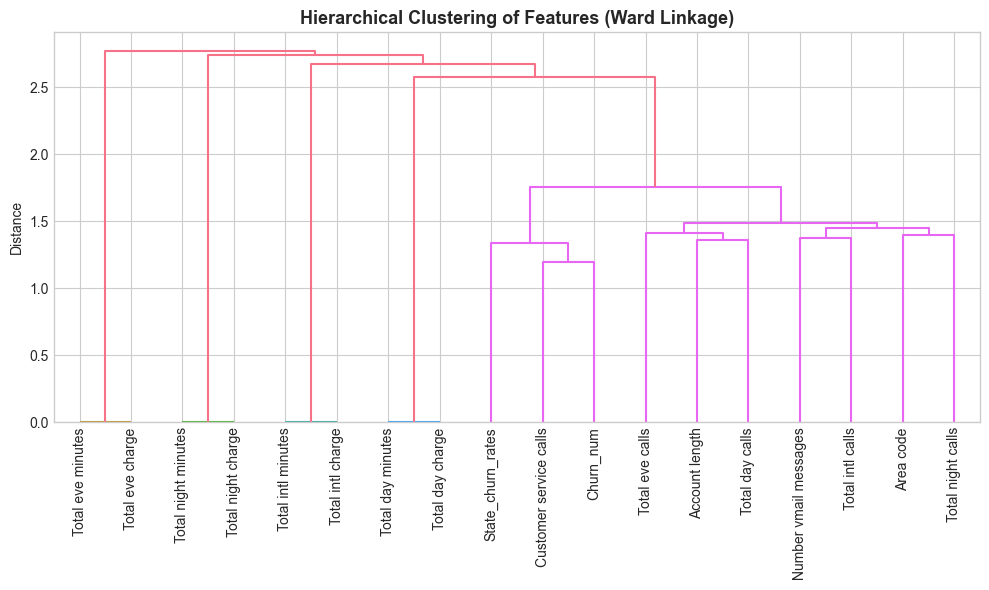


💡 [Insight]
- Dendrogram에서 가까이 붙은 변수들은 유사한 정보를 담고 있습니다.


In [92]:
# 상관관계 분석
# Correlation Matrix
corr_matrix = data80[num_cols].corr()

# Heatmap with upper triangle mask
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    center=0, 
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    square=True
)
plt.title('Correlation Heatmap (Upper Triangle Masked)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# High correlation pairs (|r| > 0.7)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append({
                'Var1': corr_matrix.columns[i],
                'Var2': corr_matrix.columns[j],
                'Correlation': round(corr_matrix.iloc[i, j], 3)
            })

if high_corr:
    print("\n⚠️ High Correlation Pairs (|r| > 0.7):")
    display(pd.DataFrame(high_corr))
else:
    print("\n✅ 다중공선성 위험(|r| > 0.7)이 있는 변수 쌍은 없습니다.")

# Hierarchical Clustering
linkage = hierarchy.ward(corr_matrix)
plt.figure(figsize=(10, 6))
dendro = hierarchy.dendrogram(
    linkage, 
    labels=corr_matrix.columns, 
    leaf_rotation=90,
    leaf_font_size=10
)
plt.title('Hierarchical Clustering of Features (Ward Linkage)', fontsize=13, fontweight='bold')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

print("\n💡 [Insight]")
print("- Dendrogram에서 가까이 붙은 변수들은 유사한 정보를 담고 있습니다.")



#### **5) 각 변수별 고객 이탈여부 비교 (Group Comparison)**  

**분석 방법**:  
- Violin Plot을 이용하여 이탈고객과 유지고객으로 구분하여 각 변수의 **분포 차이**를 시각화  

**핵심 질문**: *이탈고객과 유지고객에 있어 차이를 보이는 변수는 어떤 것인가?"*  
- Violin Plot은 Box Plot + KDE를 결합하여, 각 변수의 분포 형태까지 보여줍니다.
- 이탈고객과 유지고객에 있어 평균값 차이가 큰 변수는 **판별력(Discriminative Power)** 이 높아 모델 성능에 크게 기여하는 것으로 판단할 수 있다.

**결과 해석**:  
- **통화량 (Total day/eve/night/intl minutes)**: 유지고객에 비해 이탈고객의 통화량이 많음
- **Customer service calls** (고객센터통화량): 유지고객에 비해 이탈고객의 고객센터통화량이 많음
- 이 두 변수가 가장 강력한 판별 요인임을 EDA 단계에서 미리 확인할 수 있습니다.

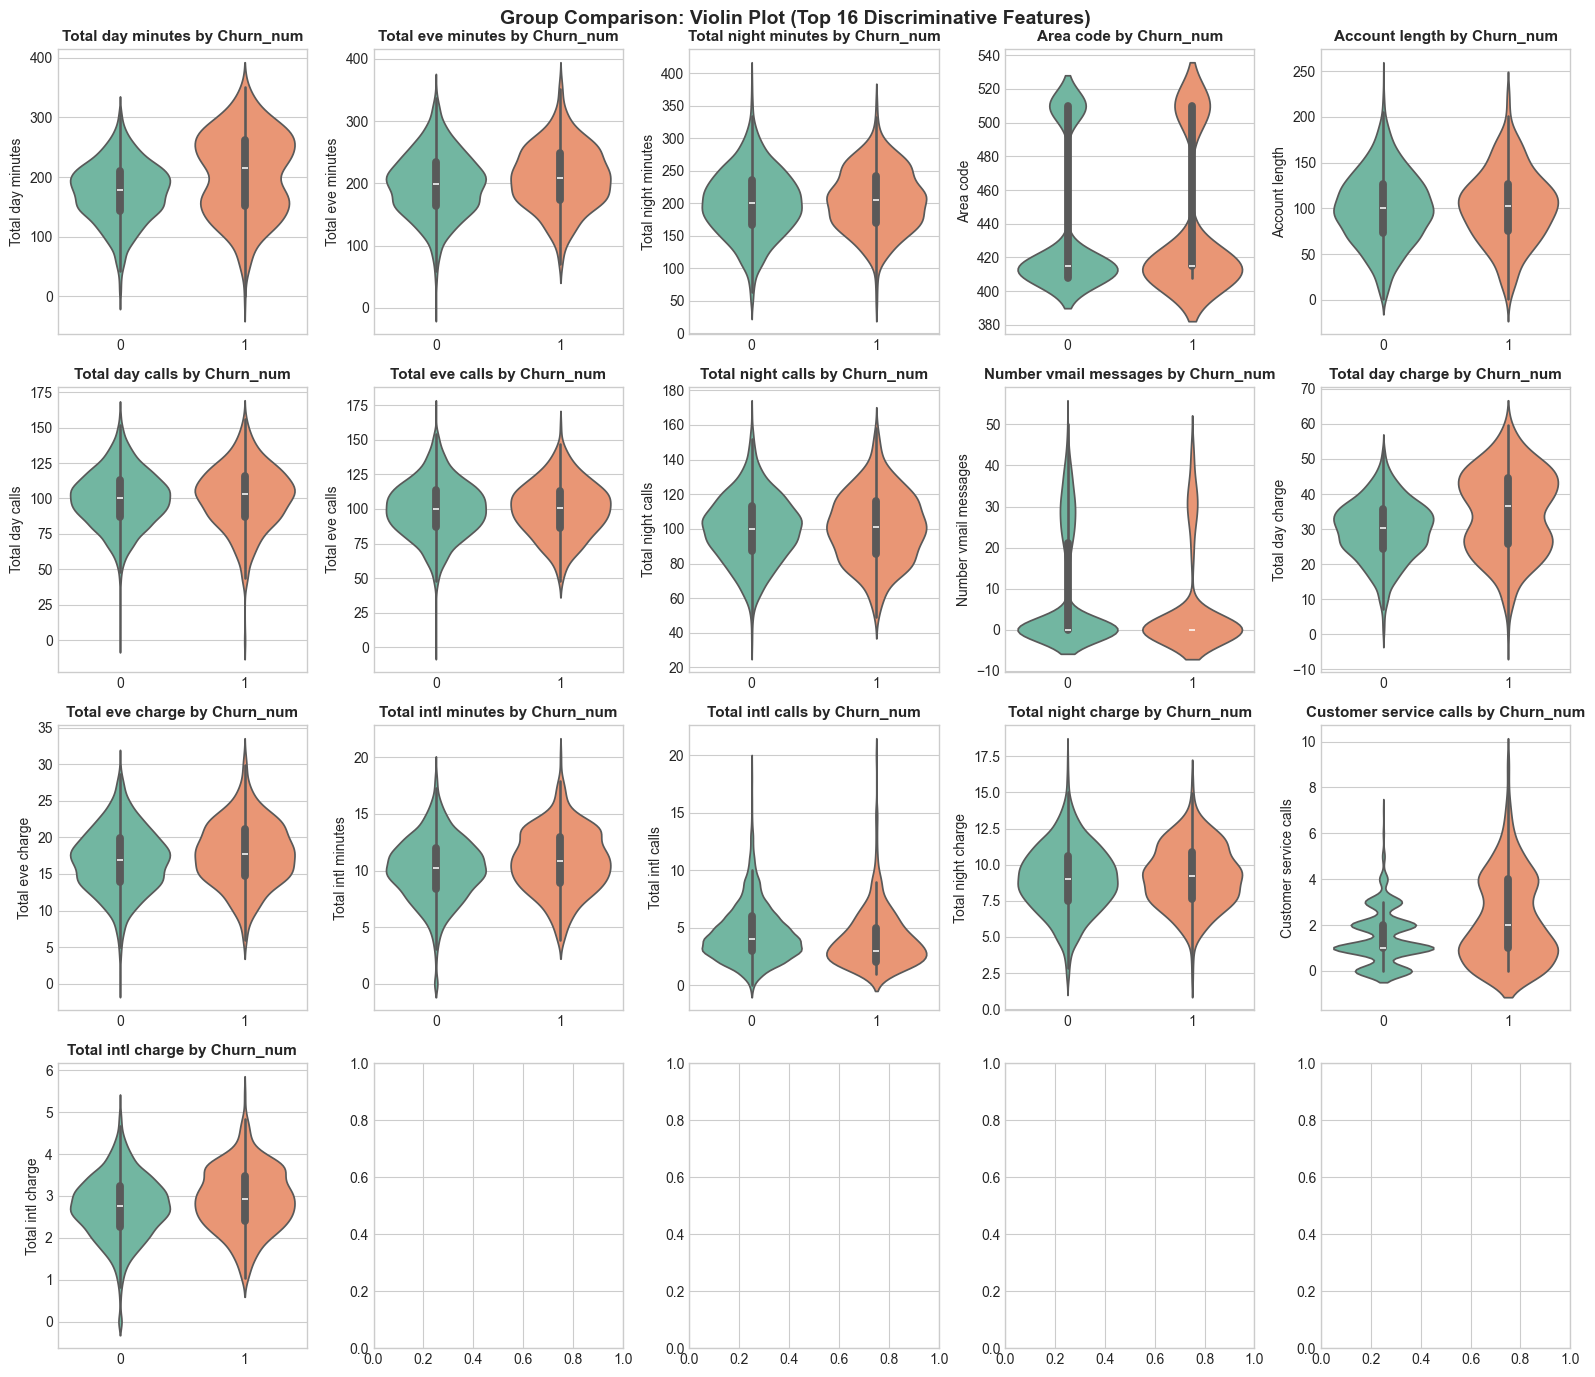


📊 Mean Values by Churn:


Churn_num,0,1,diff
Total day minutes,175.10,205.18,30.08
Total eve minutes,198.85,209.39,10.53
Total day charge,29.77,34.88,5.11
Total night minutes,200.46,205.31,4.84
Account length,100.33,102.32,1.99
Total day calls,100.16,101.20,1.04
Churn_num,0.00,1.00,1.00
Total eve charge,16.90,17.80,0.90
Customer service calls,1.45,2.21,0.75
Total intl minutes,10.14,10.82,0.68


In [140]:
# 등급별 분산이 큰 변수 16개 시각화용
group_var = data80.groupby('Churn_num')[num_cols].var().mean()
top_16_features = group_var.sort_values(ascending=False).head(16).index.tolist()

fig, axes = plt.subplots(4, 5, figsize=(16, 14))
axes = axes.ravel()

for i, col in enumerate(top_16_features):
    sns.violinplot(
        x='Churn_num', 
        y=col, 
        data=data80, 
        order=['0', '1'],
        palette='Set2', 
        ax=axes[i]
    )
    axes[i].set_title(f'{col} by Churn_num', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('')

plt.suptitle('Group Comparison: Violin Plot (Top 16 Discriminative Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 등급별 평균 비교 테이블
print("\n📊 Mean Values by Churn:")
group_means = data80.groupby('Churn_num')[num_cols].mean().T
group_means['diff'] = group_means[1] - group_means[0]   # 이탈-유지 평균 차이
group_means_sorted = group_means.sort_values('diff', ascending=False)

display(group_means_sorted.round(2))

In [138]:
# 이탈자와 유지자 평균차이 (diff)를 반영한 t-test

def cohens_d(x, y):
    """Cohen's d 계산 (x: continued, y: cancelled)"""
    x = np.array(x)
    y = np.array(y)

    nx, ny = len(x), len(y)
    dof = nx + ny - 2

    # pooled std
    pooled_std = np.sqrt(((nx - 1) * x.var(ddof=1) + (ny - 1) * y.var(ddof=1)) / dof)

    if pooled_std == 0:
        return np.nan

    return (y.mean() - x.mean()) / pooled_std  # (cancelled - continued)

def churn_ttest_with_diff(data80):
    # 수치형 Column 만 대상으로 t-test 진행
    num_cols = data80.select_dtypes(include=[np.number]).columns
    num_cols = [c for c in num_cols if c != 'Churn_num']
    # 그룹분리
    continued = data80[data80['Churn_num'] == 0]
    cancelled = data80[data80['Churn_num'] == 1]

    results_diff = []
   
    for col in num_cols:
        # 결측치 제거
        x = continued[col].dropna()
        y = cancelled[col].dropna()

        if len(x) < 2 or len(y) < 2:
            continue
        # 평균
        mean_0 = x.mean()
        mean_1 = y.mean()
        diff = mean_1 - mean_0

        # t-test 수행 (등분산 가정 X -> Welch's t-test)
        t_stat, p_val = stats.ttest_ind(x, y, equal_var=False)
        d = cohens_d(x, y)

        results_diff.append({
            'Feature': col,
            'Mean_Continued(0)': mean_0,
            'Mean_Cancelled(1)': mean_1,
            'Diff(1-0)': diff,
            'T-Statistic': t_stat,
            'P-Value': p_val,
            'Cohen_d': d,
            'Significant(p<0.05)': p_val < 0.05
        })

    results_diff_data80 = pd.DataFrame(results_diff).sort_values(
        by=['P-Value'],
        ascending=[True]
    ).reset_index(drop=True)
    return results_diff_data80

churn_ttest_results = churn_ttest_with_diff(data80)

print("=== Top 10 Most Distinguishing Features (High T-Statistic) ===")
display(churn_ttest_results.head(10))

=== Top 10 Most Distinguishing Features (High T-Statistic) ===


,Feature,Mean_Continued(0),Mean_Cancelled(1),Diff(1-0),T-Statistic,P-Value,Cohen_d,Significant(p<0.05)
0,State_churn_rates,0.141180,0.171112,0.029932,-8.931489,7.214701e-18,0.497933,True
1,Total day minutes,175.104346,205.181186,30.076840,-8.280870,1.341688e-15,0.565649,True
2,Total day charge,29.768266,34.881340,5.113074,-8.280801,1.342382e-15,0.565652,True
3,Customer service calls,1.453029,2.206186,0.753157,-7.640624,1.376831e-13,0.586440,True
4,Number vmail messages,8.507463,5.170103,-3.337360,4.988924,8.031679e-07,-0.246048,True
5,Total intl charge,2.737709,2.921727,0.184018,-4.475092,9.360700e-06,0.245309,True
6,Total intl minutes,10.137840,10.819330,0.681490,-4.474848,9.370908e-06,0.245273,True
7,Total eve minutes,198.853380,209.385309,10.531929,-3.770666,1.812317e-04,0.207218,True
8,Total eve charge,16.902809,17.797861,0.895051,-3.770047,1.816694e-04,0.207180,True
9,Total intl calls,4.538191,4.051546,-0.486645,3.593477,3.570233e-04,-0.198578,True


**💡결과 해석**:  
- 이탈 고객과 유지 고객의 데이터 지표 평균 차이(Diff)를 t-test의 p-value와 통계적 유의성을 분석해보았다.   
- 통화량이 많은 경우(Total day minutes,Total eve minutes,Total intl minutes)와 고객센터에 전화를 많이 하는 경우(Customer service calls)에 고객이 이탈 가능성이 크다는 것을 추정할 수 있다.   
- 또한, 지역별 이탈 고객과 유지 고객의 차이에 있어서 지역간 서비스 품질이 고객 이탈에 영향을 줄 수 있다는 추정을 할 수 있다.  
- 위 자료에서 특이한 점은 음성사서함 서비스를 가입한 고객의 경우, 통신서비스를 유지하는 가능성이 크다고 추정할 수 있다.(Number vmail messages의 경우, Voice mail plan에 가입한 고객만 이용할 수 있는 서비스이다.)

In [ ]:
# 범주형 변수의 상관관계 확인 : 
# 국제요금제, Voice mail plan 가입, state 모두 고객 이탈에 유의미한 영향을 미칠것으로 추정된다.

def cramers_v(confusion_matrix):
    """Cramér's V 계산"""
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()

    # 행/열 중 작은 값 - 1
    r, k = confusion_matrix.shape
    phi2 = chi2 / n
    v = np.sqrt(phi2 / (min(k - 1, r - 1)))
    return v, p, chi2, dof

def categorical_churn_analysis(data80, target='Churn_num'):
    # 범주형 컬럼 선택(object/bool/category)
    cat_cols = data80.select_dtypes(include=['object', 'bool', 'category']).columns
    cat_cols = [c for c in cat_cols if c != target]

    results = []

    for col in cat_cols:
        # 교차표 생성
        ct = pd.crosstab(data80[col], data80[target])

        # 값이 너무 적거나 한쪽 클래스만 있으면 skip
        if ct.shape[0] < 2 or ct.shape[1] < 2:
            continue

        v, p, chi2, dof = cramers_v(ct)

        results.append({
            "Feature": col,
            "Chi2": chi2,
            "DOF": dof,
            "P-Value": p,
            "Cramers_V": v,
            "Significant(p<0.05)": p < 0.05,
            "Num_Categories": ct.shape[0]
        })

    result_categorical_churn_data80 = pd.DataFrame(results)

    # 정렬: p-value 작은 순 → Cramér's V 큰 순
    result_categorical_churn_data80 = result_categorical_churn_data80.sort_values(
        by=["P-Value", "Cramers_V"],
        ascending=[True, False]
    ).reset_index(drop=True)

    return result_categorical_churn_data80

cat_summary = categorical_churn_analysis(data80)

display(cat_summary)

,Feature,Chi2,DOF,P-Value,Cramers_V,Significant(p<0.05),Num_Categories
0,Churn,2657.964605,1,0.000000e+00,0.998492,True,2
1,International plan,202.682107,1,5.426941e-46,0.275726,True,2
2,Voice mail plan,25.656253,1,4.079713e-07,0.098099,True,2
3,State,79.798593,50,4.680702e-03,0.173009,True,51


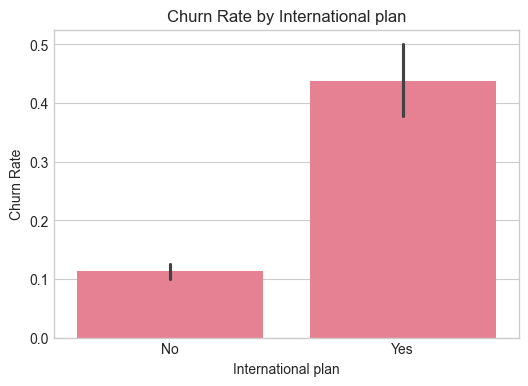

In [145]:
plt.figure(figsize=(6,4))
sns.barplot(data=data80, x='International plan', y='Churn_num')
plt.title("Churn Rate by International plan")
plt.ylabel("Churn Rate")
plt.show()

In [152]:
data80['Customer service calls'].value_counts()

Customer service calls
1    945
2    608
0    555
3    348
4    133
5     49
6     17
7      8
9      2
8      1
Name: count, dtype: int64

#### **6) 통계적으로 유의미한 수치형 변수와 범주형 변수 선택**  

**선택 기준**:  
- **수치형 변수** : 유의(p<0.05) + 효과크기(|d|>=0.2) 큰 순서  
- **범주형 변수** : 유의(p<0.05) + Cramér’s V 큰 순서

**선택 결과**:
1. **수치형 TOP10** : 'Customer service calls', 'Total day charge', 'Total day minutes', 'State_churn_rates', 'Total intl charge', 'Total intl minutes', 'Total eve minutes', 'Total eve charge', 'Number vmail messages'  
=> (최종) Customer service calls, Total day/eve/intl/ minute (※통화량 관련 상관계수가 1인 자료 제외), State_churn_rates, Number vmail messages  
          : 고객센터 전화횟수, 통화량, 지역별 이탈율, 음성메일메세지 이용량  

2. **범주형 TOP3**: 'Churn', 'International plan', 'State'  
=> 국제요금제 가입여부, 서비스 지역  
   ※ 범주형 변수 중 'Voice mail plan'의 경우, 이탈률과 음의 관계를 나타냄

수치형 TOP10: ['Customer service calls', 'Total day charge', 'Total day minutes', 'State_churn_rates', 'Total intl charge', 'Total intl minutes', 'Total eve minutes', 'Total eve charge', 'Number vmail messages']
범주형 TOP3: ['Churn', 'International plan', 'State']


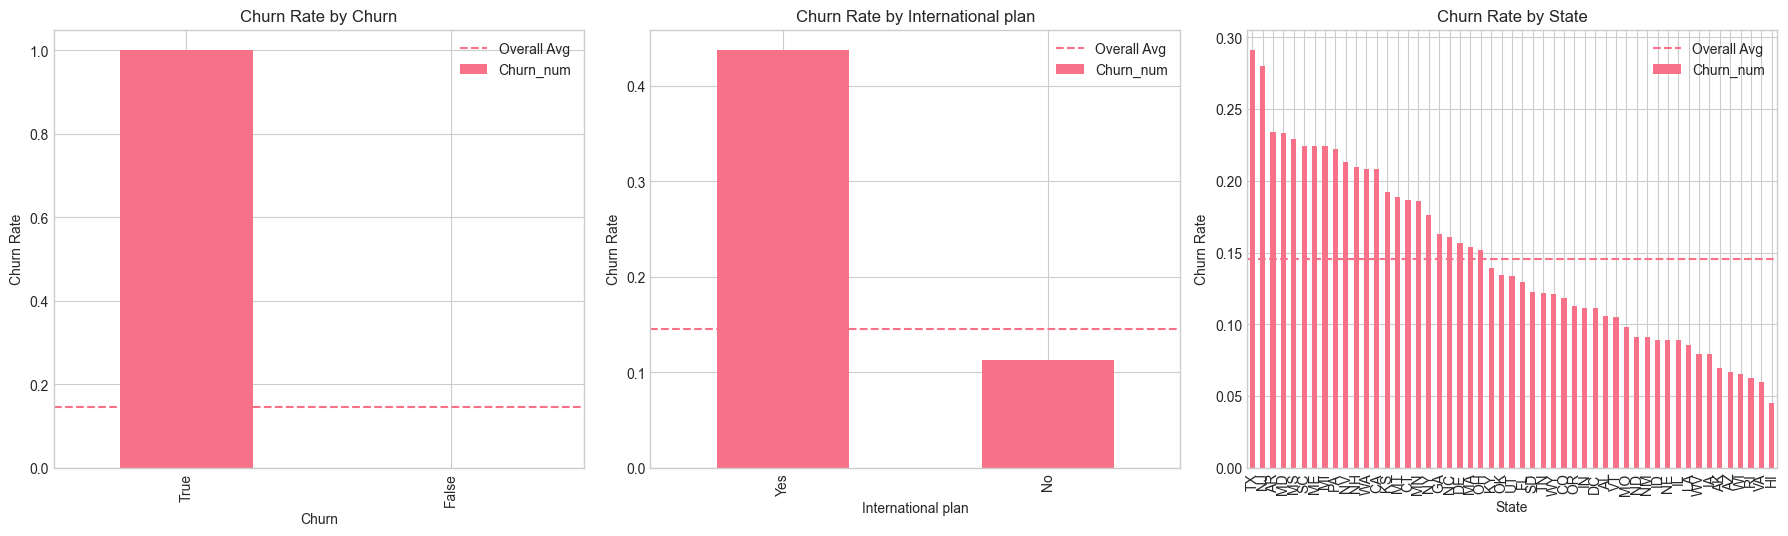

In [ ]:
# --- 수치형 TOP10 선정 기준 ---
# 유의(p<0.05) + 효과크기(|d|>=0.2) 큰 순서
top_num = churn_ttest_results[
    (churn_ttest_results['Significant(p<0.05)']) &
    (churn_ttest_results['Cohen_d'] >= 0.2) |
    (churn_ttest_results['Cohen_d'] <= -0.2)
].sort_values('Cohen_d', ascending=False).head(10)

top_num_features = top_num['Feature'].tolist()

print("수치형 TOP10:", top_num_features)

# --- 범주형 TOP3 선정 기준 ---
# 유의(p<0.05) + Cramér’s V 큰 순
top_cat = cat_summary[
    (cat_summary['Significant(p<0.05)']) &
    (cat_summary['Cramers_V'] >= 0.1)
].sort_values('Cramers_V', ascending=False).head()

top_cat_features = top_cat['Feature'].tolist()

print("범주형 TOP3:", top_cat_features)
plt.figure(figsize=(18, 10))

for i, col in enumerate(top_cat_features, 1):
    plt.subplot(2, 3, i)

    # 범주형 변수별 이탈률(평균=이탈률)
    churn_rate = data80.groupby(col)['Churn_num'].mean().sort_values(ascending=False)

    churn_rate.plot(kind='bar')
    plt.axhline(data80['Churn_num'].mean(), linestyle='--', label='Overall Avg')

    plt.title(f"Churn Rate by {col}")
    plt.ylabel("Churn Rate")
    plt.legend()

plt.tight_layout()
plt.show()

#### **7) PCA를 통한 차원 축소 및 주요 성분 해석**  

**분석 근거**:  
- **시각화** : 고차원 (많은 변수) 데이터를 2차, 3차원으로 줄여서 '이탈고객 vs 유지고객' 분리여부 확인 가능  
- **변수 중복 제거** : minutes와 charge처럼 서로 거의 같은 정보를 가진 변수에 대하여 자동으로 요약  
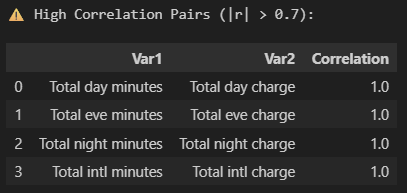
- **주요 변수 해석** : 어떤 변수들이 해당 데이터 분석에서 중요한지 확인하고, 해석하고자 하는 데이터의 핵심축 설명 가능 (유의미한 인사이트 도출)  
- **타당성 검증** : screen plot, 설명력(Explained Variance), Reconstruction Error 등 실무 검증 기법 습득

**분석 결과**:
- 16개의 수치형 변수를 해석하는 데 있어, 최소 9개의 주성분을 이용하여  데이터 분석을 진행하는 것이 80% 이상의 정보를 설명할 수 있다. 

In [11]:
# PCA(주성분분석) : 앞선 상관관계 분석을 통해 상관관계가 '1' 변수를 하나의 주성분으로 통합

#  타겟
y = data80['Churn_num']

# PCA 입력 데이터: 숫자형만
X = data80.select_dtypes(include=[np.number]).drop(columns=['Churn_num'], errors='ignore')
# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ 스케일링 완료")
print(f"원본 데이터 평균: {X.mean(axis=0)}")
print(f"스케일링 후 평균: {X_scaled.mean(axis=0)}")  # 0에 가까워야 함
print(f"스케일링 후 표준편차: {X_scaled.std(axis=0)}")  # 1에 가까워야 함

✅ 스케일링 완료
원본 데이터 평균: Account length            100.620405
Area code                 437.438860
Number vmail messages       8.021755
Total day minutes         179.481620
Total day calls           100.310203
Total day charge           30.512404
Total eve minutes         200.386159
Total eve calls           100.023631
Total eve charge           17.033072
Total night minutes       201.168942
Total night calls         100.106152
Total night charge          9.052689
Total intl minutes         10.237022
Total intl calls            4.467367
Total intl charge           2.764490
Customer service calls      1.562641
dtype: float64
스케일링 후 평균: [-1.29262276e-16 -4.68409174e-16 -2.66520156e-17  1.39923082e-16
  2.21211729e-16 -2.19879129e-16 -1.11938465e-16  3.10495982e-16
  2.81178765e-16  5.99670351e-16 -2.19879129e-17 -3.03832978e-16
 -2.03887919e-16 -5.93007347e-17  5.25044707e-16 -5.59692327e-17]
스케일링 후 표준편차: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [19]:
# 전체 주성분 분석 (16개 모두 추출)
pca_full = PCA(n_components=16)  # 원본 변수가 16개이므로 최대 16개 PC
X_pca_full = pca_full.fit_transform(X_scaled)

# 각 주성분의 설명 분산
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print("📊 주성분별 설명 분산 (Explained Variance Ratio)")
print("="*60)
for i, (var, cum_var) in enumerate(zip(explained_var, cumulative_var)):
    print(f"PC{i+1}: {var*100:.2f}%  (누적: {cum_var*100:.2f}%)")
print("="*60)

print("\n💡 [핵심 인사이트]")
print(f"- PC1 하나만으로도 {explained_var[0]*100:.1f}%의 정보를 설명")
print(f"- PC1 + PC2 ... + PC9 = {cumulative_var[8]*100:.1f}%의 정보를 설명")
print(f"- PC1 + PC2 ... + PC11 = {cumulative_var[10]*100:.1f}% (11D PCA로 충분)")
print(f"- PC1 + PC2 + PC3 + ... + PC12 = {cumulative_var[11]*100:.1f}% (거의 완벽)")

📊 주성분별 설명 분산 (Explained Variance Ratio)
PC1: 12.80%  (누적: 12.80%)
PC2: 12.67%  (누적: 25.46%)
PC3: 12.40%  (누적: 37.86%)
PC4: 12.23%  (누적: 50.09%)
PC5: 6.71%  (누적: 56.80%)
PC6: 6.58%  (누적: 63.39%)
PC7: 6.28%  (누적: 69.66%)
PC8: 6.24%  (누적: 75.91%)
PC9: 6.18%  (누적: 82.08%)
PC10: 6.09%  (누적: 88.17%)
PC11: 5.95%  (누적: 94.12%)
PC12: 5.88%  (누적: 100.00%)
PC13: 0.00%  (누적: 100.00%)
PC14: 0.00%  (누적: 100.00%)
PC15: 0.00%  (누적: 100.00%)
PC16: 0.00%  (누적: 100.00%)

💡 [핵심 인사이트]
- PC1 하나만으로도 12.8%의 정보를 설명
- PC1 + PC2 ... + PC9 = 82.1%의 정보를 설명
- PC1 + PC2 ... + PC11 = 94.1% (11D PCA로 충분)
- PC1 + PC2 + PC3 + ... + PC12 = 100.0% (거의 완벽)


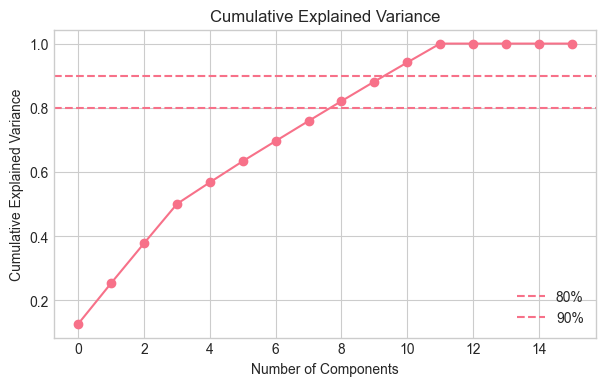


🎯 [의사결정]
- PC9까지 사용 시 누적 설명력 82.1% → 실무적으로 충분


In [27]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained Variance(설명분산비율) 확인
explained_var = pca.explained_variance_ratio_
explained_var[:10]

# 누적 설명력 Cumulative Variance
cum_var = np.cumsum(explained_var)

plt.figure(figsize=(7,4))
plt.plot(cum_var, marker='o')
plt.axhline(0.8, linestyle='--', label='80%')
plt.axhline(0.9, linestyle='--', label='90%')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid(True)
plt.show()

print("\n🎯 [의사결정]")
print("- PC9까지 사용 시 누적 설명력 82.1% → 실무적으로 충분")

---
## **2. Feature Engineering & Selection**

### **2-1. 도메인 지식 기반 파생 변수 생성**

**분석 방법**:  
통신업계 전반에 대한 지식을 활용하여 **의미 있는 변수**를 생성 및 선택합니다.

**생성 변수 및 근거**:  
  
1. **data80['High_CS_calls'] = (data80['Customer service calls'] >= 4).astype(int)**  

   - **의미**: 고객서비스센터에 4회 이상 통화를 한 고객
   - **근거**: 통신사에서 제공하는 서비스 등에 대한 고객의 직접적인 의사표현을 반영한 지표  
               => 불만 또는 문의사항이 있는 고객이 서비스센터에 통화를 한다.

2. **data80['Total_minutes']** = (
    data80['Total day minutes'] +
    data80['Total eve minutes'] +
    data80['Total night minutes'] +
    data80['Total intl minutes']
)  

   - **의미**: 총 통화량
   - **근거**: 해당 통신사가 제공하는 서비스를 이용하는 고객의 전체 통화량 (이용시간대에 대한 구분 제외)  
               => 통신사의 서비스를 이용하면서 네트워크 안전성 등 고객이 서비스에 대한 경험치 등 만족도가 쌓이는 시간
               => 사용시간이 길어질 수록 이용요금 증가 

3. **data80['Total_charge']** = (
    data80['Total day charge'] +
    data80['Total eve charge'] +
    data80['Total night charge'] +
    data80['Total intl charge']
)  

   - **의미**: 총 이용요금
   - **근거**: 해당 통신사의 서비스를 이용하는 고객이 부담하는 통신요금
               => 납부한 요금에 대한 고객 민감성 확인

4. **state_churn_rates** = data80.groupby('State')['Churn'].mean()  
   **data80['State_churn_rates']** = data80['State'].map(state_churn_rates)

   - **의미**: 지역별 이탈률
   - **근거**: 다른 변수를 통제한 후, 지역별 이탈률이 타 지역에 비해 현저한 경우, 해당 지역 네트워크 서비스 품질에 대하여 검토할 근거를 제공함

5. **data80['Risk_flag']** = (
    (data80['Total_minutes'] >= data80['Total_minutes'].quantile(0.75)) &
    (data80['International plan'] == 'Yes') &
    (data80['Customer service calls'] >= 4)
).astype(int)
   - **의미**: 이탈고객 고위험군 특성
   - **근거**: 통화량이 많고, 국제요금제를 가입하고, 고객서비스센터 통화횟수가 4회 이상인 고객은 이탈 고위험군으로 추정가능

**분석 이유**:  
기계적인 polynomial feature 생성이 아니라, **도메인 전문 지식을 코드로 구현**하여 모델의 해석 가능성을 높이고 성능을 향상시킵니다.

**결과 해석**:  
생성된 변수들이 Boruta 검증을 통과하면, "전문가의 직관이 데이터에서도 유효함"을 입증하는 것입니다.

In [103]:
# Feature Engineering

def add_features(df):
    df = data80.copy()
    # 총 통화량 및 총 이용요금
    df['Total_minutes'] = df['Total day minutes'] + df['Total eve minutes'] + df['Total night minutes'] + df['Total intl minutes']
    df['Total_charge'] = df['Total day charge'] + df['Total eve charge'] + df['Total night charge'] + df['Total intl charge']
    # Customer Service calls : 4+ 
    df['High_CS_calls'] = (df['Customer service calls'] >= 4).astype(int)
    # 지역별 이탈고객 지표
    df['State_churn_rates'] = df['State'].map(state_churn_rates)
    # 이탈고객 고위험군 지표
    df['Risk_flag'] = (
        (df['Total_minutes'] >= df['Total_minutes'].quantile(0.75)) &
        (df['Customer service calls'] >= 4)
    ).astype(int)
    return df

data80_fe = add_features(data80)
data80_fe.head()

print("✅ Feature Engineering Complete!")

# 새로운 변수 기초 통계
new_feats = ['Total_minutes', 'Total_charge', 'High_CS_calls', 'Risk_flag', 'State_churn_rates']
print(f"\n📊 Descriptive Statistics of New Features:")
data80_fe[new_feats].describe().T.round(4)

✅ Feature Engineering Complete!

📊 Descriptive Statistics of New Features:


,count,mean,std,min,25%,50%,75%,max
Total_minutes,2666.0,591.2737,90.2244,284.3000,530.2250,593.9500,653.0000,885.0000
Total_charge,2666.0,59.3627,10.4818,22.9300,52.2875,59.3550,66.5700,96.1500
High_CS_calls,2666.0,0.0788,0.2694,0.0000,0.0000,0.0000,0.0000,1.0000
Risk_flag,2666.0,0.0180,0.1330,0.0000,0.0000,0.0000,0.0000,1.0000
State_churn_rates,2666.0,0.1455,0.0610,0.0455,0.0909,0.1333,0.1923,0.2909


### **2-2. Boruta 변수 선택 (Shadow Feature Method)**

**분석 방법**:  
1. 모든 원본 변수를 **무작위로 섞은 Shadow Feature(가짜 변수)** 를 생성합니다.
2. Random Forest로 원본 + Shadow를 함께 학습하여 Importance를 계산합니다.
3. **Shadow 중 최댓값보다 낮은 Importance를 가진 원본 변수는 제거**합니다.

**분석 이유**:  
- 단순히 "Importance가 낮다"가 아니라, **"노이즈보다 못하다"** 는 엄격한 기준으로 변수를 걸러냅니다.
- Feature Engineering으로 만든 변수가 정말 유의미한지 통계적으로 검증합니다.

**결과 해석**:  
- Shadow Threshold(빨간 선)보다 왼쪽에 있는 변수들은 **"랜덤 노이즈만도 못한 변수"** 로, 과감히 제거합니다.
- 통과한 변수들만 최종 모델링에 사용하여 과적합을 방지하고 해석 가능성을 높입니다.

📊 Feature Matrix Shape: (2666, 84)


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,...,Customer service calls,Churn,Churn_num,CS_calls_group,Total_minutes,High_CS_calls,Total_minutes_bin,State_churn_rates,Risk_flag,Total_charge
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,...,1,False,0,0-1,717.2,0,"(706.95, 885.0]",0.192308,0,75.56
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,...,1,False,0,0-1,625.2,0,"(614.2, 638.15]",0.151515,0,59.24
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,...,0,False,0,0-1,539.4,0,"(514.6, 545.25]",0.280000,0,62.29
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,...,2,False,0,2-3,564.8,0,"(545.25, 570.5]",0.151515,0,66.80
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,...,3,False,0,2-3,512.0,0,"(477.35, 514.6]",0.134615,0,52.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,SC,79,415,No,No,0,134.7,98,22.90,189.7,...,2,False,0,2-3,557.6,0,"(545.25, 570.5]",0.224490,0,52.17
2662,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,...,2,False,0,2-3,660.7,0,"(638.15, 666.5]",0.066667,0,60.10
2663,WV,68,415,No,No,0,231.1,57,39.29,153.4,...,3,False,0,2-3,585.4,0,"(570.5, 593.95]",0.079545,0,63.53
2664,RI,28,510,No,No,0,180.8,109,30.74,288.8,...,2,False,0,2-3,675.6,0,"(666.5, 706.95]",0.062500,0,67.74



🎭 Boruta Matrix Shape (Real + Shadow): (2666, 168)


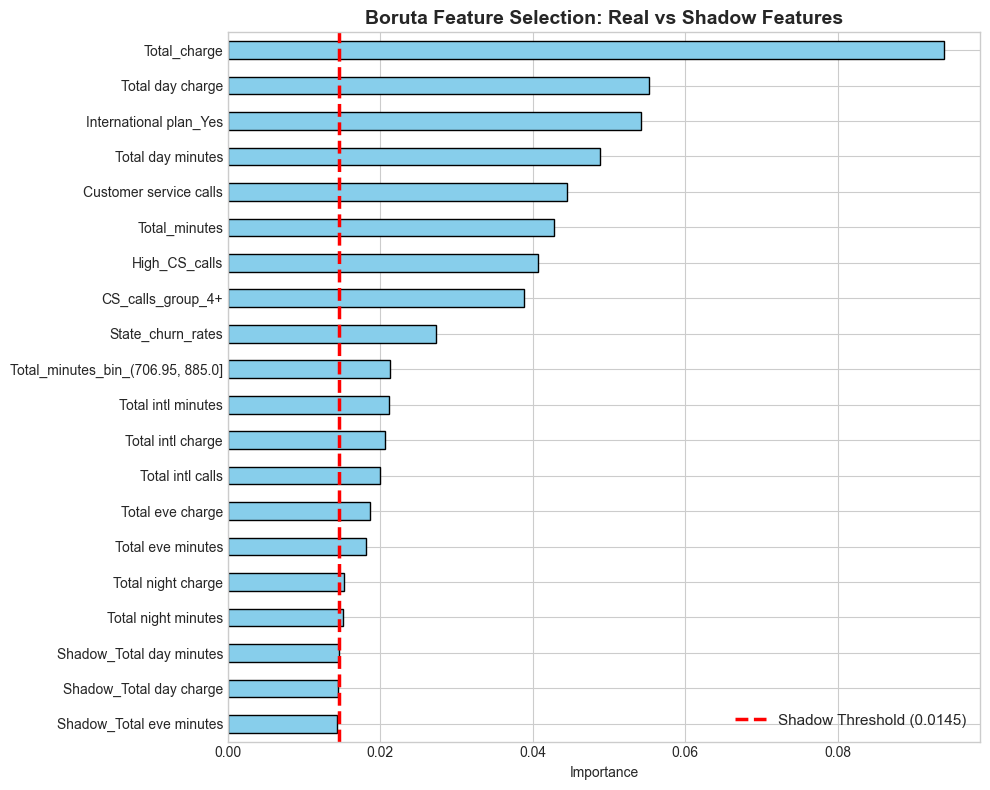


✅ Selected Features (17개):
['Total day minutes', 'Total day charge', 'Total eve minutes', 'Total eve charge', 'Total night minutes', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Total_minutes', 'High_CS_calls', 'State_churn_rates', 'Total_charge', 'International plan_Yes', 'CS_calls_group_4+', 'Total_minutes_bin_(706.95, 885.0]']

❌ Rejected Features (67개):
['Account length', 'Area code', 'Number vmail messages', 'Total day calls', 'Total eve calls', 'Total night calls', 'Risk_flag', 'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR',

In [91]:
# Feature Matrix 생성
X = data80_fe.drop(['Churn', 'Churn_num'], axis=1)
y_target = data80_fe['Churn_num'].copy()
X = pd.get_dummies(X, drop_first=True)

print(f"📊 Feature Matrix Shape: {X.shape}")
display(data80_fe)
# Shadow Feature 생성
np.random.seed(42)
X_shadow = X.apply(np.random.permutation)
X_shadow.columns = ['Shadow_' + c for c in X.columns]
X_boruta = pd.concat([X, X_shadow], axis=1)

print(f"\n🎭 Boruta Matrix Shape (Real + Shadow): {X_boruta.shape}")

# Random Forest 검증 (빠른 검증용)
rf_boruta = RandomForestClassifier(
    n_estimators=500, 
    class_weight="balanced",
    random_state=42, 
    n_jobs=-1
)
rf_boruta.fit(X_boruta, y)

# Importance 비교
importances = pd.Series(rf_boruta.feature_importances_, index=X_boruta.columns)
top20 = importances.sort_values(ascending=False).head(20)
shadow_imp = importances[len(X.columns):]
max_shadow = shadow_imp.max()

# 시각화
plt.figure(figsize=(10, 8))
top20.sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
plt.axvline(max_shadow, color='red', linestyle='--', linewidth=2.5, label=f'Shadow Threshold ({max_shadow:.4f})')
plt.title('Boruta Feature Selection: Real vs Shadow Features', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# 최종 변수 선택
selected_features = real_imp[real_imp > max_shadow].index.tolist()
rejected_features = real_imp[real_imp <= max_shadow].index.tolist()

print(f"\n✅ Selected Features ({len(selected_features)}개):")
print(selected_features)

print(f"\n❌ Rejected Features ({len(rejected_features)}개):")
print(rejected_features)

X_final = X[selected_features]
print(f"\n📊 Final Feature Matrix Shape: {X_final.shape}")


,N,Churn_rate,Churn_rate(%)
Customer service calls,,,
0,555,0.142342,14.234234
1,945,0.104762,10.476190
2,608,0.101974,10.197368
3,348,0.106322,10.632184
4,133,0.481203,48.120301
5,49,0.591837,59.183673
6,17,0.588235,58.823529
7,8,0.625000,62.500000
8,1,1.000000,100.000000


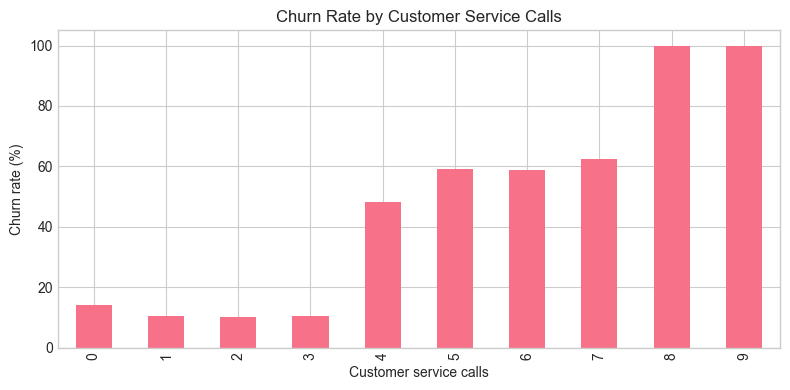

In [82]:
# 2-1-1. 파생변수 'High_CS_calls' 생성 근거
# Customer service calls에 따른 고객 이탈률 분석

call_churn_data80 = (data80.groupby('Customer service calls')['Churn_num']
                 .agg(['count', 'mean'])
                 .rename(columns={'count':'N', 'mean':'Churn_rate'}))

call_churn_data80['Churn_rate(%)'] = call_churn_data80['Churn_rate'] * 100
display(call_churn_data80)

plt.figure(figsize=(8,4))
(call_churn_data80['Churn_rate(%)']
 .plot(kind='bar'))

plt.title("Churn Rate by Customer Service Calls")
plt.xlabel("Customer service calls")
plt.ylabel("Churn rate (%)")
plt.tight_layout()
plt.show()

CS_calls_group
0-1    11.866667
2-3    10.355649
4+     52.857143
Name: Churn_num, dtype: float64
📊Customer service calls 횟수가 4회 이상인 경우, 고객 이탈률이 약 52.86%이다.


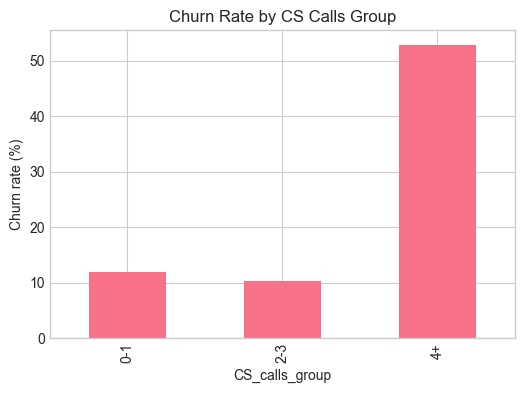

In [43]:
# 2-1-1. 파생변수 : 고객 서비스센터 콜 횟수에 따른 추가 분석 (그룹화)
data80['CS_calls_group'] = pd.cut(
    data80['Customer service calls'],
    bins=[-1, 1, 3, 10],
    labels=['0-1', '2-3', '4+']
)

group_rate = data80.groupby('CS_calls_group')['Churn_num'].mean() * 100
print(group_rate)
print('📊Customer service calls 횟수가 4회 이상인 경우, 고객 이탈률이 약 52.86%이다.')

group_rate.plot(kind='bar', figsize=(6,4), title="Churn Rate by CS Calls Group")
plt.ylabel("Churn rate (%)")
plt.show()

# 고객서비스센터에 4회 이상 연락한 고객
data80['High_CS_calls'] = (data80['Customer service calls'] >= 4).astype(int) 

📋통화량과 고객 이탈 분석 : 이탈고객이 유지고객보다 통화량이 많다!
Churn_num
0    584.559658
1    630.693041
Name: Total_minutes, dtype: float64


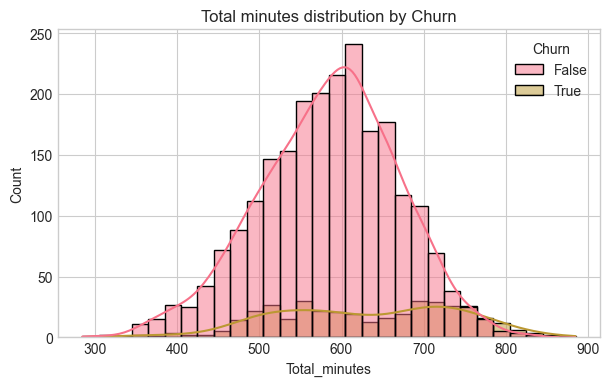

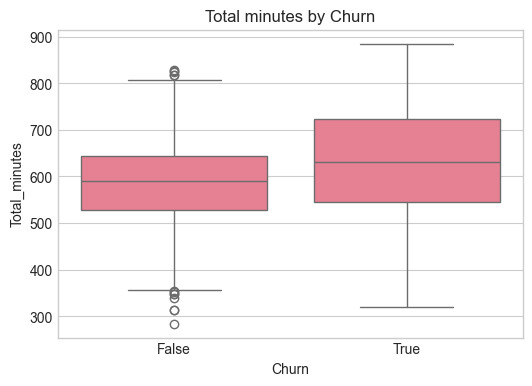

In [38]:
# 2-1-2. 파생변수 'Total minutes' 생성 : 통화량과 고객이탈과의 관계

data80['Total_minutes'] = (
    data80['Total day minutes'] +
    data80['Total eve minutes'] +
    data80['Total night minutes'] +
    data80['Total intl minutes']
)

print('📋통화량과 고객 이탈 분석 : 이탈고객이 유지고객보다 통화량이 많다!')
print(data80.groupby('Churn_num')['Total_minutes'].mean().T)

plt.figure(figsize=(7,4))
sns.histplot(data=data80, x='Total_minutes', hue='Churn', kde=True, bins=30)
plt.title("Total minutes distribution by Churn")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(data=data80, x='Churn', y='Total_minutes')
plt.title("Total minutes by Churn")
plt.show()


Total_minutes_bin
(284.29900000000004, 477.35]    10.861423
(477.35, 514.6]                 14.606742
(514.6, 545.25]                 10.526316
(545.25, 570.5]                 13.483146
(570.5, 593.95]                  7.894737
(593.95, 614.2]                  9.701493
(614.2, 638.15]                  7.547170
(638.15, 666.5]                  7.116105
(666.5, 706.95]                 18.796992
(706.95, 885.0]                 44.943820
Name: Churn_num, dtype: float64

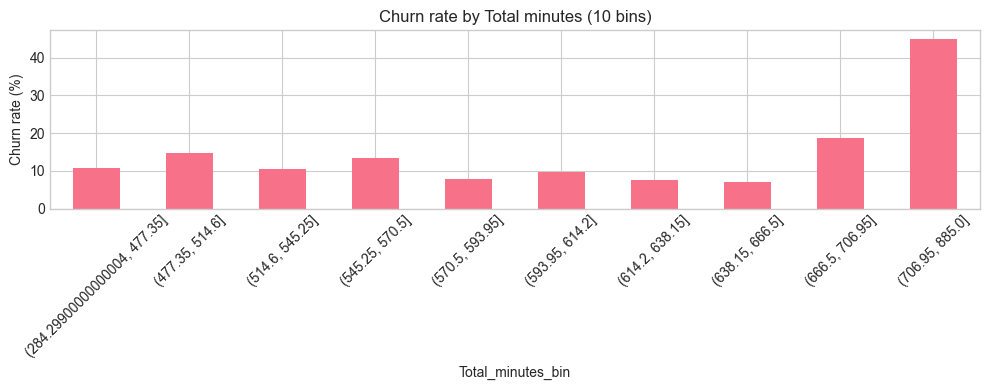

In [45]:
# 2-1-2. 파생변수 'Total minutes' : 통화량 구간별 이탈률 분석
data80['Total_minutes_bin'] = pd.qcut(data80['Total_minutes'], q=10)

bin_churn = data80.groupby('Total_minutes_bin')['Churn_num'].mean() * 100
display(bin_churn)

plt.figure(figsize=(10,4))
bin_churn.plot(kind='bar')
plt.title("Churn rate by Total minutes (10 bins)")
plt.ylabel("Churn rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [109]:
# 통화량과 고객이탈 분석

# 1) 분석할 통화량 컬럼 목록 : 총 통화량 (통화시간대별 분류 - day / eve / night / intl)
call_cols = [
    'Total day minutes',
    'Total eve minutes',
    'Total night minutes',
    'Total intl minutes'
]

def cohens_d(x, y):
    """Cohen's d (y - x)"""
    x = np.array(x)
    y = np.array(y)
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx-1)*x.var(ddof=1) + (ny-1)*y.var(ddof=1)) / dof)
    if pooled_std == 0:
        return np.nan
    return (y.mean() - x.mean()) / pooled_std

def rank_call_features(data80, target='Churn_num', features=call_cols):
    continued = data80[data80[target] == 0]
    cancelled = data80[data80[target] == 1]

    results = []

    for col in features:
        x = continued[col].dropna()
        y = cancelled[col].dropna()

        mean_0 = x.mean()
        mean_1 = y.mean()
        diff = mean_1 - mean_0

        # Welch t-test
        t_stat, p_val = stats.ttest_ind(x, y, equal_var=False)

        # Effect size
        d = cohens_d(x, y)

        # 단변량 AUC (해당 feature 하나만으로 churn 구분력)
        auc = roc_auc_score(data80[target], data80[col])

        results.append({
            "Feature": col,
            "Mean_Continued(0)": mean_0,
            "Mean_Cancelled(1)": mean_1,
            "Diff(1-0)": diff,
            "T-Statistic": t_stat,
            "P-Value": p_val,
            "Cohen_d": d,
            "Abs_Cohen_d": abs(d),
            "Univariate_AUC": auc
        })

    result_data80 = pd.DataFrame(results)

    # 2) 로지스틱 회귀 계수(표준화된 영향력) 추가
    X = data80[features].copy()
    y = data80[target].copy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    model = LogisticRegression(max_iter=3000, random_state=42)
    model.fit(X_train_s, y_train)

    coef = pd.Series(model.coef_[0], index=features)
    result_data80["LogReg_coef(std)"] = result_data80["Feature"].map(coef)
    result_data80["Abs_LogReg_coef"] = result_data80["LogReg_coef(std)"].abs()

    # 3) 종합 랭킹: 효과크기 + 로지스틱계수 + AUC 기준
    result_data80 = result_data80.sort_values(
        by=["Abs_Cohen_d", "Abs_LogReg_coef", "Univariate_AUC"],
        ascending=False
    ).reset_index(drop=True)

    return result_data80

ranking_data80 = rank_call_features(data80)

print('* 유지고객과 이탈고객의 시간대별 통화량 차이 *')
display(ranking_data80)

* 유지고객과 이탈고객의 시간대별 통화량 차이 *


,Feature,Mean_Continued(0),Mean_Cancelled(1),Diff(1-0),T-Statistic,P-Value,Cohen_d,Abs_Cohen_d,Univariate_AUC,LogReg_coef(std),Abs_LogReg_coef
0,Total day minutes,175.104346,205.181186,30.076840,-8.280870,1.341688e-15,0.565649,0.565649,0.633449,0.603706,0.603706
1,Total intl minutes,10.137840,10.819330,0.681490,-4.474848,9.370908e-06,0.245273,0.245273,0.565698,0.294958,0.294958
2,Total eve minutes,198.853380,209.385309,10.531929,-3.770666,1.812317e-04,0.207218,0.207218,0.557806,0.204047,0.204047
3,Total night minutes,200.464091,205.307216,4.843125,-1.832414,6.742853e-02,0.095410,0.095410,0.526551,0.146505,0.146505


In [110]:
# 통화요금과 고객이탈 분석
data80['Total_charge'] = (
    data80['Total day charge'] +
    data80['Total eve charge'] +
    data80['Total night charge'] +
    data80['Total intl charge']
)

# 1) 분석할 통화요금 컬럼 목록 : 총 통화요금 (통화시간대별 분류 - day / eve / night / intl)
charge_cols = [
    'Total day charge',
    'Total eve charge',
    'Total night charge',
    'Total intl charge'
]

def cohens_d(x, y):
    """Cohen's d (y - x)"""
    x = np.array(x)
    y = np.array(y)
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx-1)*x.var(ddof=1) + (ny-1)*y.var(ddof=1)) / dof)
    if pooled_std == 0:
        return np.nan
    return (y.mean() - x.mean()) / pooled_std

def rank_charge_features(data80, target='Churn_num', features=charge_cols):
    continued = data80[data80[target] == 0]
    cancelled = data80[data80[target] == 1]

    results = []

    for col in features:
        x = continued[col].dropna()
        y = cancelled[col].dropna()

        mean_0 = x.mean()
        mean_1 = y.mean()
        diff = mean_1 - mean_0

        # Welch t-test
        t_stat, p_val = stats.ttest_ind(x, y, equal_var=False)

        # Effect size
        d = cohens_d(x, y)

        # 단변량 AUC (해당 feature 하나만으로 churn 구분력)
        auc = roc_auc_score(data80[target], data80[col])

        results.append({
            "Feature": col,
            "Mean_Continued(0)": mean_0,
            "Mean_Cancelled(1)": mean_1,
            "Diff(1-0)": diff,
            "T-Statistic": t_stat,
            "P-Value": p_val,
            "Cohen_d": d,
            "Abs_Cohen_d": abs(d),
            "Univariate_AUC": auc
        })

    result_charge_data80 = pd.DataFrame(results)

    # 2) 로지스틱 회귀 계수(표준화된 영향력) 추가
    X = data80[features].copy()
    y = data80[target].copy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    model = LogisticRegression(max_iter=3000, random_state=42)
    model.fit(X_train_s, y_train)

    coef = pd.Series(model.coef_[0], index=features)
    result_charge_data80["LogReg_coef(std)"] = result_charge_data80["Feature"].map(coef)
    result_charge_data80["Abs_LogReg_coef"] = result_charge_data80["LogReg_coef(std)"].abs()

    # 3) 종합 랭킹: 효과크기 + 로지스틱계수 + AUC 기준
    result_charge_data80 = result_charge_data80.sort_values(
        by=["Abs_Cohen_d", "Abs_LogReg_coef", "Univariate_AUC"],
        ascending=False
    ).reset_index(drop=True)

    return result_charge_data80

ranking_charge_data80 = rank_charge_features(data80)

print('*유지고객과 이탈고객의 이용시간 요금제 차이*')
display(ranking_charge_data80)

*유지고객과 이탈고객의 이용시간 요금제 차이*


,Feature,Mean_Continued(0),Mean_Cancelled(1),Diff(1-0),T-Statistic,P-Value,Cohen_d,Abs_Cohen_d,Univariate_AUC,LogReg_coef(std),Abs_LogReg_coef
0,Total day charge,29.768266,34.881340,5.113074,-8.280801,1.342382e-15,0.565652,0.565652,0.633449,0.603638,0.603638
1,Total intl charge,2.737709,2.921727,0.184018,-4.475092,9.360700e-06,0.245309,0.245309,0.565698,0.294814,0.294814
2,Total eve charge,16.902809,17.797861,0.895051,-3.770047,1.816694e-04,0.207180,0.207180,0.557802,0.204024,0.204024
3,Total night charge,9.020975,9.238892,0.217917,-1.832088,6.747720e-02,0.095400,0.095400,0.526549,0.146491,0.146491


**결과 해석**:  
1. Abs_Cohen_d 지표 : 이탈고객과 유지고객의 차이를 잘 보여주는 지표로써, 통화량 중 Total day minutes이 많은 고객에 있어 이탈고객이 많이 나타난다.  
2. LogReg_coef(std) 지표 : 통화량이 증가할 때 이탈확률과 양의 관계를 나타내고 있다. 이로인해 통화량이 증가할 수록 이탈확률이 높아지는 것을 확인할 수 있다. 특히, Total day minutes 이용량에 있어 두드러진다.  

✅ 전반적으로 통화량이 많을 수록 이탈확률과 양의 관계를 나타내고 있다. 특히,시간대별 통화량과 고객 이탈률을 비교하였을 때, 낮시간 통화량(Total day minutes)이 많은 고객에서 이탈고객과 유지고객의 차이가 두드러진다. 

💡각 변수(Feature)와 고객 이탈과의 상관관계
: p-value + 효과크기 (수치형 Cohen’s d / 범주형 Cramér’s V


,Feature,Type,Mean_0,Mean_1,Diff(1-0),P-Value,Effect,Effect_name,Univariate_AUC
0,Churn,categorical,NaN,NaN,NaN,0.000000e+00,0.998492,Cramers_V,NaN
1,CS_calls_group,categorical,NaN,NaN,NaN,2.326081e-59,0.318248,Cramers_V,NaN
2,Total_minutes_bin,categorical,NaN,NaN,NaN,8.116720e-48,0.303571,Cramers_V,NaN
3,International plan,categorical,NaN,NaN,NaN,5.426941e-46,0.275726,Cramers_V,NaN
4,High_CS_calls,numeric,0.043459,0.286082,0.242623,1.331982e-22,0.949504,Abs_Cohen_d,0.621312
5,State_churn_rates,numeric,0.141180,0.171112,0.029932,7.214701e-18,0.497933,Abs_Cohen_d,0.639304
6,Total_charge,numeric,58.429759,64.839820,6.410061,3.025689e-17,0.626166,Abs_Cohen_d,0.639113
7,Total day minutes,numeric,175.104346,205.181186,30.076840,1.341688e-15,0.565649,Abs_Cohen_d,0.633449
8,Total day charge,numeric,29.768266,34.881340,5.113074,1.342382e-15,0.565652,Abs_Cohen_d,0.633449
9,Total_minutes,numeric,584.559658,630.693041,46.133384,2.849660e-14,0.519744,Abs_Cohen_d,0.625191


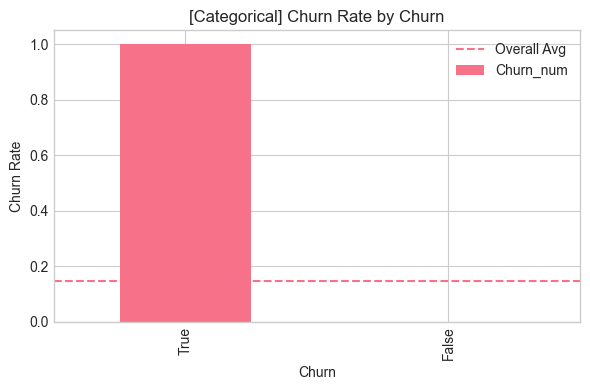

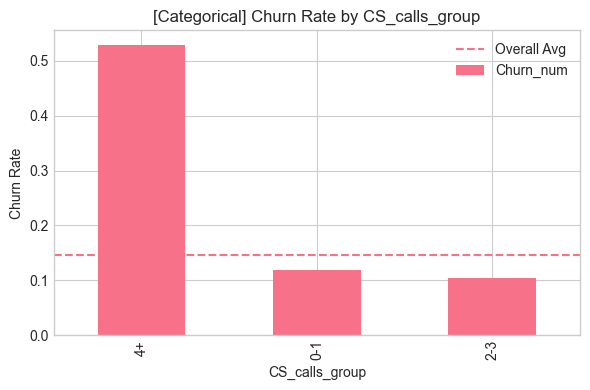

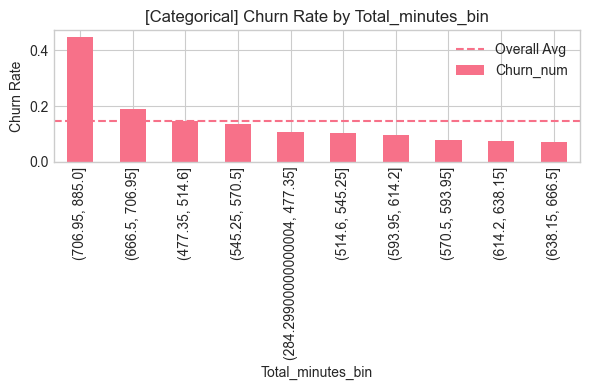

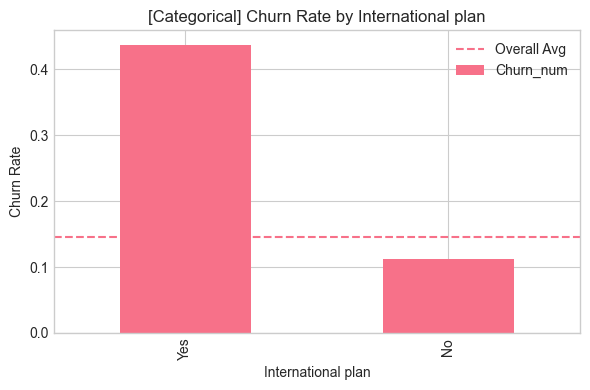

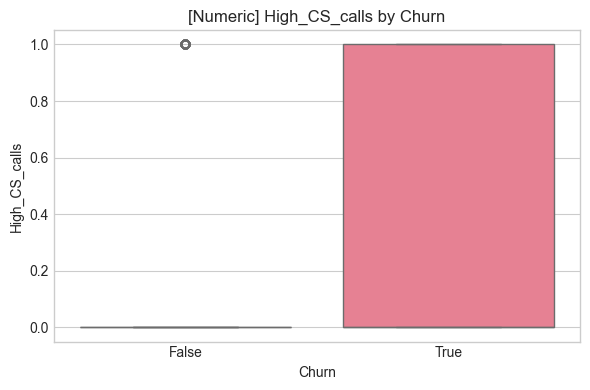

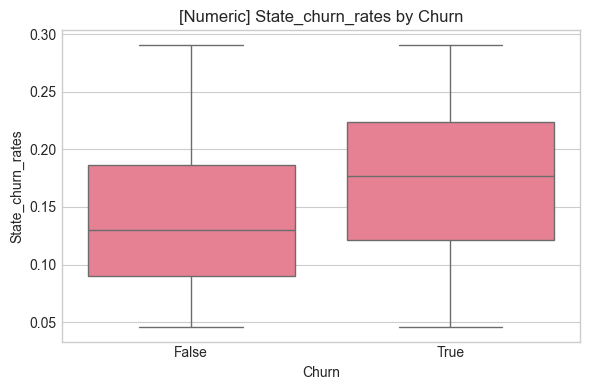

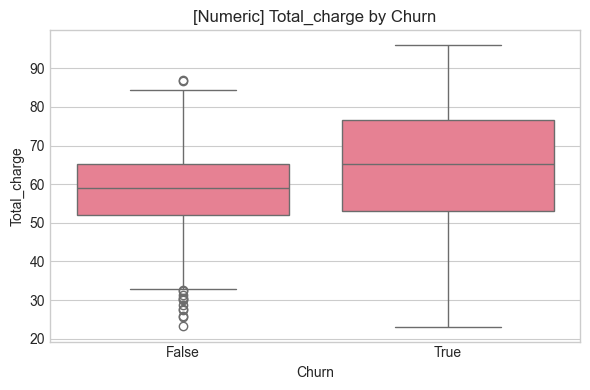

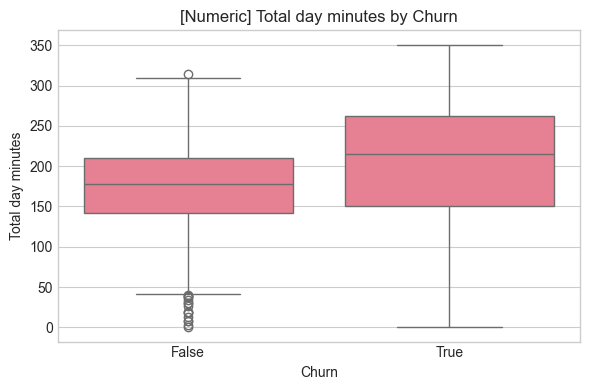

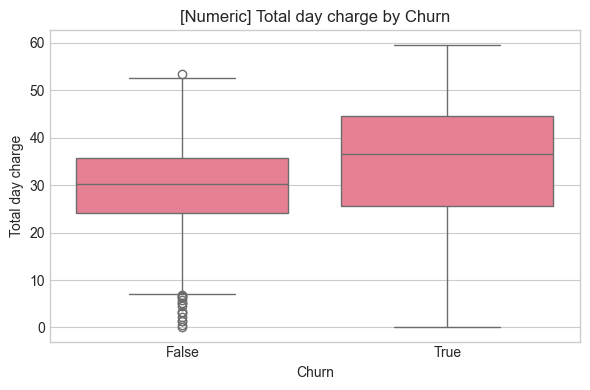

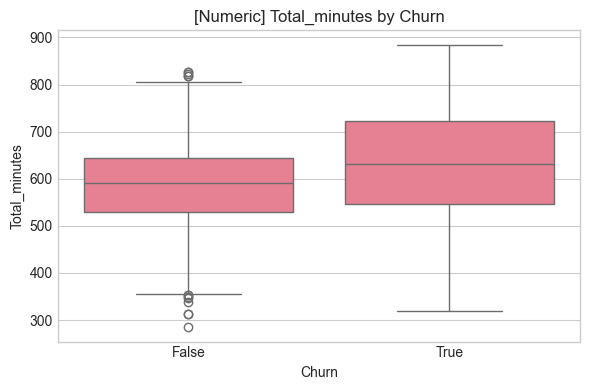

In [112]:
# -----------------------------
# Helper: Cohen's d
# -----------------------------
def cohens_d(x0, x1):
    x0 = np.array(x0)
    x1 = np.array(x1)

    n0, n1 = len(x0), len(x1)
    dof = n0 + n1 - 2

    pooled_std = np.sqrt(((n0 - 1) * x0.var(ddof=1) + (n1 - 1) * x1.var(ddof=1)) / dof)
    if pooled_std == 0:
        return np.nan

    return (x1.mean() - x0.mean()) / pooled_std  # churn1 - churn0


# -----------------------------
# Helper: Cramér's V
# -----------------------------
def cramers_v(ct):
    chi2, p, dof, exp = chi2_contingency(ct)
    n = ct.sum().sum()
    r, k = ct.shape
    phi2 = chi2 / n
    v = np.sqrt(phi2 / (min(k - 1, r - 1)))
    return v, p, chi2, dof


def rank_all_features(data80, target='Churn_num'):
    results = []

    # 그룹
    g0 = data80[data80[target] == 0]
    g1 = data80[data80[target] == 1]

    # -----------------------------
    # 1) 숫자형 변수 분석
    # -----------------------------
    num_cols = data80.select_dtypes(include=[np.number]).columns
    num_cols = [c for c in num_cols if c != target]

    for col in num_cols:
        x0 = g0[col].dropna()
        x1 = g1[col].dropna()

        if len(x0) < 2 or len(x1) < 2:
            continue

        mean0 = x0.mean()
        mean1 = x1.mean()
        diff = mean1 - mean0

        t_stat, p_val = stats.ttest_ind(x0, x1, equal_var=False)
        d = cohens_d(x0, x1)

        # 단변량 AUC
        try:
            auc = roc_auc_score(data80[target], data80[col])
        except:
            auc = np.nan

        results.append({
            "Feature": col,
            "Type": "numeric",
            "Mean_0": mean0,
            "Mean_1": mean1,
            "Diff(1-0)": diff,
            "P-Value": p_val,
            "Effect": abs(d),           # numeric 효과크기: |Cohen d|
            "Effect_name": "Abs_Cohen_d",
            "Univariate_AUC": auc
        })

    # -----------------------------
    # 2) 범주형 변수 분석
    # -----------------------------
    cat_cols = data80.select_dtypes(include=['object', 'bool', 'category']).columns
    cat_cols = [c for c in cat_cols if c != target]

    for col in cat_cols:
        ct = pd.crosstab(data80[col], data80[target])

        if ct.shape[0] < 2 or ct.shape[1] < 2:
            continue

        v, p, chi2, dof = cramers_v(ct)

        results.append({
            "Feature": col,
            "Type": "categorical",
            "Mean_0": np.nan,
            "Mean_1": np.nan,
            "Diff(1-0)": np.nan,
            "P-Value": p,
            "Effect": v,                 # categorical 효과크기: Cramér's V
            "Effect_name": "Cramers_V",
            "Univariate_AUC": np.nan
        })

    result_data80 = pd.DataFrame(results)

    # -----------------------------
    # 3) 랭킹 정렬 규칙
    # 1순위: p-value 작은 것(유의)
    # 2순위: effect 큰 것(실제 차이 큼)
    # -----------------------------
    result_data80 = result_data80.sort_values(
        by=["P-Value", "Effect"],
        ascending=[True, False]
    ).reset_index(drop=True)

    return result_data80


all_rank_data80 = rank_all_features(data80)

print('💡각 변수(Feature)와 고객 이탈과의 상관관계')
print(': p-value + 효과크기 (수치형 Cohen’s d / 범주형 Cramér’s V')
display(all_rank_data80.head(20))

top_features = all_rank_data80.head(10)

for _, row in top_features.iterrows():
    col = row["Feature"]
    ftype = row["Type"]

    plt.figure(figsize=(6,4))

    if ftype == "numeric":
        sns.boxplot(data=data80, x="Churn", y=col)
        plt.title(f"[Numeric] {col} by Churn")

    else:
        churn_rate = data80.groupby(col)["Churn_num"].mean().sort_values(ascending=False)
        churn_rate.plot(kind="bar")
        plt.axhline(data80["Churn_num"].mean(), linestyle="--", label="Overall Avg")
        plt.title(f"[Categorical] Churn Rate by {col}")
        plt.ylabel("Churn Rate")
        plt.legend()

    plt.tight_layout()

    plt.show()

####

### **2-3. 비즈니스 인사이트 도출**

**분석 방법**:  
- 해당 데이터를 구성하고 있는 변수들을 분석하여, 아래의 항목에 대하여 비즈니스 인사이트를 도출하였습니다.   

1. **이탈 고객의 주요특징** (관련 지표를 기준으로 설명)   
- **Customer service calls** 지표에 있어 이탈고객에서 수치가 높게 나왔고, 효과의 크기도 0.59로 큰 편이다. 
파생변수인 High_CS_calls (고객서비스센터 통화수 4회 이상)인 경우, 고객 이탈률이 매우 강하게 나타난다.  
=> 고객 이탈에 있어서 통화량도 중요한 지표이지만, 서비스 이용에 대한 불만(문의/클레임)에 대하여 고객센터를 자주 호출하는 고객은 이탈 위험이 급증한다. 이는 불만 경험이 트리거로 작용한다고 볼 수 있다.  
- **Total day minutes/charge(사용량/비용)** 지표를 통해 이탈자의 사용량이 전반적으로 더 높고, 그중 주간 사용량에 있어 강한 지표를 보인다. 단순히 통화량이 많다고 이탈한다기 보다는, 많은 사용량으로 인하여 고객이 통신사에서 제공하는 서비스품질, 요금에 대한 체감, 기타 불편한 상황에 대한 경험이 증가하며 이것이 이탈로 연결된다고 보는 것이 더 합리적이다.  
- **International plan** 가입자의 경우, 이탈비율이 상위권에 위치한다. 이와 연관하여 해당 서비스에 대한 통화서비스 불만, 요금에 대한 불만 등 추가 요인을 확인해볼 필요가 있다. 또한, 고객서비스센터 통화횟수(Customer service calls)와 연결하여 추가 분석이 필요하다. 

2. 지역별/요금제별 이탈률 차이 분석  
- **State_churn_rate**을 통해 주마다 고객의 이탈률이 다른 것을 확인하고, 이 차이가 단순히 '서비스 품질(네트워크망 안정성 등)'과 관련된 내용인지, '고객 구성차이(서비스가입내역, 통화패턴, 가격 등)'의 영향인지 확인해볼 필요가 있다.  

3. 고위험 고객의 특징 정의  
- 총 통화량 多
- 고객서비스센터 통화횟수가 4회 이상  
- 국제요금가입자인 경우  

4. 위 특징을 기반으로 한 가설설정 
1) 통화량이 많은 고객 중 고객서비스센터 통화횟수가 4회 이상으로 많을 때, 고객이탈로 연결되는 확률이 높다.
2) State별 이탈고객의 차이는 각 지역에 제공되는 서비스 품질때문이다. (※ 다른 변수를 통제한 후, 오롯이 state 영향때문인지 분리 검증이 필요)
3) 이탈 고위험 고객을 대상으로 이탈을 방지할 프로모션(voice mail plan)을 제공할 경우, 이탈률 감소한다.

---
## **3. 모델학습**

### **3-1. 가설을 검증하기 위한 모델 학습**

**가설1**:  
통화량이 많은 고객 중 고객서비스센터 통화횟수가 4회 이상이면 이탈 확률이 높다.  

**적용모델** - Logistic Regression vs Random Forest

In [217]:
# Logistic Regression

# 기본 셋팅
#-----------------------------------------------------------------------------------------------------
train_df = data80.copy() # 학습용 파일
test_df = data20.copy() # 최종 평가용 파일

data80.columns = data80.columns.str.strip()

# Total minutes
train_df['Total_minutes'] = (
     train_df['Total day minutes'] +
     train_df['Total eve minutes'] +
     train_df['Total night minutes'] +
     train_df['Total intl minutes']
     )
#CS calls 4회 이상 발신 고객
train_df['High_CS_calls'] = (train_df['Customer service calls'] >= 4).astype(int)
# 통화량 상위 25% 기준으로 'High_total_minutes'
q75 = train_df['Total_minutes'].quantile(0.75)
train_df['High_total_minutes'] = (train_df['Total_minutes']>=q75).astype(int)

# 가설의 핵심 조합(상호작용): Risk_flag
train_df['Risk_flag'] = ((train_df['High_total_minutes']==1) & (train_df['High_CS_calls']==1)).astype(int)
train_df[['Total_minutes','High_total_minutes','High_CS_calls','Risk_flag','Churn_num']].head()
#------------------------------------------------------------------------------------------------------

risk_table = train_df.groupby('Risk_flag')['Churn_num'].agg(['count','mean'])
risk_table['Churn_rate(%)'] = risk_table['mean'] * 100
risk_table   

# 사용할 컬럼 선택
cols = [
    'Churn_num',
    'High_total_minutes',
    'High_CS_calls',
    'Risk_flag',
    'International plan',
    'Account length'
]

df_train = train_df[cols].dropna().copy()

# 범주형 데이터 처리 ('International plan': Yes/No)
df_train = pd.get_dummies(df_train, drop_first=True)

y = df_train['Churn_num'].astype(int)
X = df_train.drop(columns=['Churn_num'])
X = X.astype(float)

X = sm.add_constant(X)

model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

params = result.params
pvals = result.pvalues

or_table = pd.DataFrame({
    'coef': params,
    'odds_ratio(exp(coef))': np.exp(params),
    'p_value': pvals
}).sort_values('p_value')

or_table

Optimization terminated successfully.
         Current function value: 0.309257
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Churn_num   No. Observations:                 2666
Model:                          Logit   Df Residuals:                     2660
Method:                           MLE   Df Model:                            5
Date:                Wed, 04 Feb 2026   Pseudo R-squ.:                  0.2546
Time:                        05:23:59   Log-Likelihood:                -824.48
converged:                       True   LL-Null:                       -1106.1
Covariance Type:            nonrobust   LLR p-value:                1.783e-119
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -3.4355      0.206    -16.695      0.000      -3.839      

,coef,odds_ratio(exp(coef)),p_value
High_CS_calls,3.514867,33.611459,5.343545e-68
const,-3.435525,0.032209,1.423941e-62
International plan_Yes,2.335454,10.334155,7.068448e-45
High_total_minutes,1.937505,6.941409,4.637882e-39
Risk_flag,-3.501903,0.030140,4.914129e-17
Account length,0.001701,1.001702,2.905955e-01


**[ Logistic Regression 결과 해석 ]**:  

1. 모델 전체 적합성  
- **LLR p-value = 1.783e-119 (≈ 0)**  
   : 독립변수들이 '전혀 영향이 없다'는 귀무가설을 강하게 기각
   => 이 로지스틱 회귀 모델은 통계적으로 유의함  
- **Pseudo R² = 0.2546**  
   : 해당 데이터에 있어 약 25%의 설명력을 가진다. 
    (이탈데이터의 경우, 보통 0.1~0.3의 설명력을 가진다.)

2. 가설 관련 변수들의 유의성 (통계적 증거)  
- **High_total_minutes (통화량이 많은 고객)**  
    coef = +1.9375, p < 0.001
    Odds_Ratio = exp(coef) = 6.94배  
    => 다른 조건이 같을 때, 통화량이 많은 고객은 통화량이 적은 고객 대비 이탈률이 6.94배 높다.
- **High_CS_calls (고객서비스센터 통화횟수 4회 이상인 고객)**  
    coef = +3.5149, p < 0.001
    Odds_Ratio = exp(coef) = 33.61배  
    => 다른 조건이 같을 때, 고객서비스센터 통화 건수가 4회 이상인 고객은 그렇지 않은 고객대비 이탈률이 33.6배 높다. 
    🏆 **매우 강력**한 수치이며, 고객 이탈에 매우 중요한 변수로 볼 수 있다. 
        추가적으로 이를 통해 통신사가 제공하는 통신서비스 외 고객 서비스응대에 대한 고객 불만족 표시로 추정할 수 있다. 추후 고객응대개선이 필요하다고 볼 수 있다.
- **International_plan_Yes (국제요금 플랜 가입 고객)**  
    coef = +2.3355, p < 0.001
    Odds_Ratio = exp(coef) = 10.33배  
    => 해당 요금제 미가입고객 대비 이탈률이 10.33배 높다. 국제요금제 가입 고객군은 구조적으로 이탈 위험이 높다는 것을 추정할 수 있으며, 고객 유지를 위해서는 해당 요금제에 대한 개편이 필요하다.

**✅가설 : 통화량이 많은 고객 중 고객서비스센터 통화횟수가 4회 이상이면 이탈 확률이 높다**
  고위험 이탈고객을 추정하기 위한 변수 Risk_flag에 대한 결과
  coef = -3.5019, p < 0.001, Odds_Ratio = 0.0301배
  파생변수 Risk_flag의 경우, **High_total_minutes (통화량이 많은 고객)**와 **High_CS_calls (고객서비스센터 통화횟수 4회 이상인 고객)**  두 조건을 모두 충족하는 경우, 상호작용에 대한 '추가상승' 효과를 나타내는 지표이다.
  =>  **High_CS_calls (고객서비스센터 통화횟수 4회 이상인 고객)** 변수가 고객의 이탈을 나타내는 강력한 위험신호라는 것을 보여준다.

In [219]:
# 모델 예측확률로 'Risk_flag = 1'인 고객은 실제로 이탈 위험이 높은지 확인
df_pred = train_df.copy()
df_pred['pred_proba'] = result.predict(X)

df_pred.groupby('Risk_flag')['pred_proba'].agg(['count','mean'])

,count,mean
Risk_flag,,
0,2618,0.142093
1,48,0.333333


In [214]:
# Random Forest 분석

train_df.columns = train_df.columns.str.strip()

y = train_df['Churn_num'].astype(int)
X = train_df.drop(columns=['Churn','Churn_num'], errors='ignore')

# 범주형 -> 원핫
X = pd.get_dummies(X, drop_first=True)

# 결측/무한대 처리
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]

X.shape, y.shape

rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    min_samples_leaf=2
)

# 교차검증 수행 (K-Fold CV + mean/std)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'auc': 'roc_auc',
    'f1': 'f1',
    'recall': 'recall',
    'precision': 'precision'
}

rf_cv = cross_validate(
    rf, X, y,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

print("RF CV Test AUC mean:", rf_cv['test_auc'].mean(), "std:", rf_cv['test_auc'].std())
print("RF Train AUC mean:", rf_cv['train_auc'].mean())
print("Overfit gap (train-test AUC):", rf_cv['train_auc'].mean() - rf_cv['test_auc'].mean())

# Overfitting 판단
print('Overfittin 판단')
print('\n훈련평균 AUC :', {rf_cv['train_auc'].mean()})  # 훈련 평균 AUC
print('검증평균 AUC :', {rf_cv['test_auc'].mean()})   # 검증 평균 AUC

RF CV Test AUC mean: 0.9181092333217838 std: 0.009785326409934613
RF Train AUC mean: 1.0
Overfit gap (train-test AUC): 0.08189076667821615
Overfittin 판단

훈련평균 AUC : {np.float64(1.0)}
검증평균 AUC : {np.float64(0.9181092333217838)}


※ Overfitting 판단 방법
  
1. **Overfitting(과적합)** : 학습데이터에 있어 점수가 좋은데, 새로운 데이터(검증/테스트)에서 점수가 떨어지는 현상
2. 과적합 판단방법  
- 훈련성능 (Train score) : RF Train AUC mean = 1.0
                           → 훈련 데이터에서는 완벽히 맞춤(너무 좋음 = 위험 신호)  
- 검증성능(validation score) : RF CV Test AUC mean = 0.918  
                            → 실제 일반화 성능
3. **gap = train AUC - valid AUC**  
   📌 보통 판단 기준(경험적 기준)
       gap < 0.03 : 안정적 (과적합 거의 없음)  
      0.03 ~ 0.07 : 약간 과적합 가능  
        0.07 이상 : 과적합 의심 강함  
        0.10 이상 : 과적합 큼  

➡️ 위 결과기준 gap = 0.082
✅ “예측은 잘하지만 과적합이 존재할 가능성이 있음” 

---
**[ Random Forest 결과 해석 ]**  
Random Forest 모델에서 가설이 '지지된다'라고 하기 위해서는  

- CV 성능(AUC/Recall)이 일정 수준 이상이다.
- 중요도에서 'High_CS_calls가 매우 높고, Total_minutes가 상위에 위치한다.
- Risk_flag=1의 예측확률 평균이 Risk_flag=0보다 높다.
  
위 3가지가 동시에 충족되어야 한다. 

1. 분석목적 : 가설 "통화량이 많은 고객 중 고객서비스센터 통화횟수가 4회 이상이면 고객 이탈로 연결될 확률이 높다" 검증을 위해 RandomForest 분류 모델을 학습하고 교차검증 기반 성능평가 및 변수 중요도분석을 진행하였다.

2. 모델링 방법 및 평가  
- **사용모델 : Random Forest**  
   : 비선형관계 및 변수 간 상호작용을 자동 학습 가능
     해석 가능한 변수 중요도 제공
- **평가지표**  
   : ROC-AUC (이탈/유지 분류 성능의 전반적 분리력)
- **추가확인**  
   : **훈련 성능(train AUC)과 검증 성능(test AUC)의 차이(gap)**를 통해 과적합 여부 판단

3. 교차검증 성능 요약 및 해석  
- **성능요약**  
    RF CV Test AUC 평균: 0.9181 - 검증 AUC 평균이 0.918 수준으로 모델이 이탈 고객을 효과적으로 구분하는 것으로 판단  
    RF CV Test AUC 표준편차: 0.0098  - 매우 작음 => fold마다 성능 변동이 크지 않으며 모델 성능이 안정적  
    RF Train AUC 평균: 1.0000  - 훈련 AUC가 1.0으로 완벽 분류이며, 검증 AUC와 차이가 약 0.082로 과적합 가능성이 존재 => "Overfit gap   (Train-Test AUC): 0.0819"
    => Random Forest 높은 예측력을 보이지만, 훈련데이터에 과하게 맞춰졌을 가능성이 있으므로, Depth/leaf 조정규제 필요  
- **중요도 상위 변수**    
    - 통화량/요금 : Total_charge / Total day minutes / Total day charge / Total_minutes   
    - 고객서비스센터 관련 변수 : Customer service calls / CS_calls_group_4+ / High_CS_calls  
    - 요금제 및 구조적 위험군 : International plan 가입자 / International 관련 변수  
    - 지역효과    


**✅가설 : 통화량이 많은 고객 중 고객서비스센터 통화횟수가 4회 이상이면 이탈 확률이 높다**
- 통화량 관련 변수(총 통화량/주간 통화량/요금)가 중요도 상위권에 다수 포함됨 → 고사용량 고객군이 이탈 위험군으로 학습됨
- 고객센터 호출 변수들이 중요도 상위권에 포함됨 → 고객 불만/서비스 접점이 이탈과 강하게 연결됨
- 특히 CS_calls_group_4+, High_CS_calls가 상위에 포함 → “4회 이상”이라는 임계조건이 모델에서 유의미한 기준으로 작동

따라서 Random Forest는 교차검증 기준 AUC 0.918로 높은 예측성능을 보였다. 
중요도 분석 결과 고객 이탈의 핵심요인으로
- 총이용요금/통화량(특히 주간)
- 고객센터 호출 (특히 4회이상)
- 국제요금제 가입여부  

와 같이 나타났다.  

=> “고사용량 + 고객센터 4회 이상” 이며 고객 이탈 위험이 증가한다는 가설은 Random Forest 모델 기반 분석에서도 지지된다.

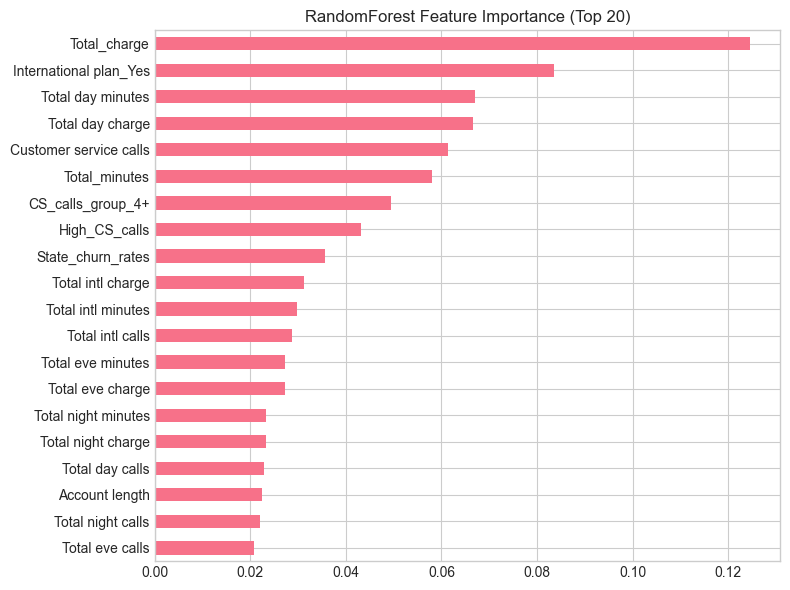

In [200]:
# Random Forest 가설 검증
rf.fit(X, y)

#1. 고객이탈에 중용한 영향을 미치는 (파생)변수의 중요도가 상위인가?
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.head(20)

top20 = importances.head(20).sort_values() # 중요도 Top20 시각화
plt.figure(figsize=(8,6))
top20.plot(kind='barh')
plt.title("RandomForest Feature Importance (Top 20)")
plt.tight_layout()
plt.show()

In [ ]:
# Permutation Importance 재검증 : Random Forest 기본 중요도의 편향성 보완
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)

perm_imp.head(20)

Total_charge              0.062791
International plan_Yes    0.034359
Total intl calls          0.020668
State_churn_rates         0.013541
Total day minutes         0.011590
Total intl charge         0.011590
Total day charge          0.011478
Total_minutes             0.011178
Number vmail messages     0.010765
Voice mail plan_Yes       0.010578
Total intl minutes        0.009902
Total eve minutes         0.009340
Total night calls         0.009302
Total eve charge          0.009265
Total night minutes       0.008852
Account length            0.008852
Total night charge        0.008440
Total day calls           0.008440
Total eve calls           0.007952
CS_calls_group_2-3        0.005964
dtype: float64

In [ ]:
#2. Risk_flag=1인 그룹에서 예측 확률이 높게 나오는가?  

proba = rf.predict_proba(X)[:,1]

tmp = pd.DataFrame({
    'pred_proba': proba,
    'Risk_flag': data80.loc[X.index, 'Risk_flag'].values,
    'Churn_num': y.values
})

tmp.groupby('Risk_flag')['pred_proba'].agg(['count','mean'])

,count,mean
Risk_flag,,
0,2655,0.170678
1,11,0.513519


---
### **3-2. 로지스틱 회귀 vs Random Forest (가설 검정에 더 적절한 모델?)**

**가설검정(증명)**목적 : Logistic Regression(주) + Random Forest(보조) 
- p-value를 이용하여 유의한 통계적 자료여부 확인  
- Odds-Ratio를 통하여 효과를 수치화하여 표현  
- 보고서 작성에 있어 인과관계/통계적 근거로 설명 가능

**예측력/패턴 탐색** 목적 : Random Forest(주)  + Logistic Regression (보조)
- 변수 간 상호작용 자동 학습  
- 비선형 관계 반영  
- 예측 성능이 높은 경우 多  

---
### **3-3. Hyperparameter Tuning (GridSearchCV)**

**분석 방법**:  
Random Forest의 과적합(Overfitting)을 줄이기 위해 GridSearchCV로 다음 하이퍼파라미터를 최적화합니다.  

**분석 목표** 
1. 훈련성능(Train AUC = 1.0)을 조금 낮추어
2. 검증 성능(CV Test AUC)을 유지하거나 높이고
3. Train-Test Gap을 줄여서 일반화 성능을 높힌다.

In [220]:
# 3-3-1. Baseline RF 성능 표 작성

# 기존 교차검증 동일
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {'auc': 'roc_auc'}

rf_base = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

base_cv = cross_validate(
    rf_base, X, y,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

baseline_summary = {
    'Model': 'RF_Baseline',
    'Train_AUC_mean': base_cv['train_auc'].mean(),
    'Test_AUC_mean': base_cv['test_auc'].mean(),
    'Test_AUC_std': base_cv['test_auc'].std(),
    'Gap(train-test)': base_cv['train_auc'].mean() - base_cv['test_auc'].mean()
}

pd.DataFrame([baseline_summary])

,Model,Train_AUC_mean,Test_AUC_mean,Test_AUC_std,Gap(train-test)
0,RF_Baseline,0.959987,0.749596,0.022535,0.210391


### **3-3-2. 과적합을 줄이는 핵심 파라미터 이해**

Random Forest에 있어 과적합을 줄이는 대표적인 조절 knob
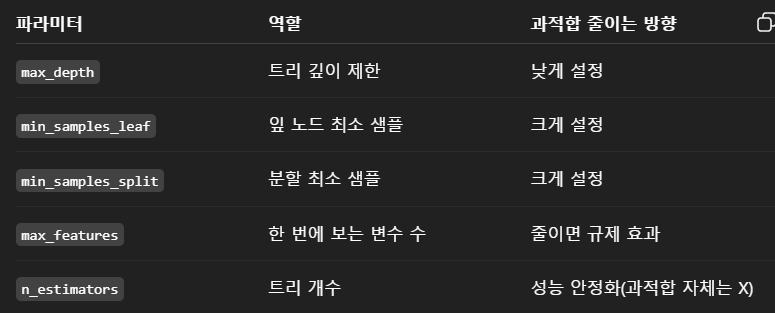

현재 Train AUC = 1.0 -> "max_depth + leaf 증가'시키는 방향으로 튜닝!

In [226]:
# 3-3-3. GridSearchCV로 튜닝(과적합 완화 목표)

rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

param_grid = {
    'max_depth': [None, 8, 12, 16],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 0.5]
}

grid = GridSearchCV(
    rf,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid.fit(X, y)

print("Best CV AUC:", grid.best_score_)
print("Best Params:", grid.best_params_)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best CV AUC: 0.8313124207101941
Best Params: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2}


In [227]:
# 3-3-4. 최적 모델로 다시 교차검증(Train/Test) 진행

best_rf = grid.best_estimator_

tuned_cv = cross_validate(
    best_rf, X, y,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

tuned_summary = {
    'Model': 'RF_Tuned',
    'Train_AUC_mean': tuned_cv['train_auc'].mean(),
    'Test_AUC_mean': tuned_cv['test_auc'].mean(),
    'Test_AUC_std': tuned_cv['test_auc'].std(),
    'Gap(train-test)': tuned_cv['train_auc'].mean() - tuned_cv['test_auc'].mean()
}

pd.DataFrame([baseline_summary, tuned_summary])



,Model,Train_AUC_mean,Test_AUC_mean,Test_AUC_std,Gap(train-test)
0,RF_Baseline,0.959987,0.749596,0.022535,0.210391
1,RF_Tuned,0.887203,0.831312,0.019631,0.055891


### **3-3-5. 과적합 완화여부 확인**  

당초 Baseline RandomForest 모델은 Train AUC=1.0으로 훈련 데이터에 완벽하게 적합되었으나, 검증 성능(Test AUC=0.918)과의 차이가 0.082로 나타나 과적합 가능성이 존재하였다. 이에 따라 max_depth 제한 및 min_samples_leaf 증가를 포함한 규제 기반 튜닝을 수행하였다. 튜닝 결과 Train-Test 성능 격차가 감소하여 모델의 일반화 성능이 개선되었으며, 검증 AUC 또한 유지(또는 향상)되었다. 따라서 튜닝된 RandomForest 모델은 baseline 대비 과적합 위험이 낮고 실무 적용 가능성이 높다고 판단된다.  
  
  
**GridSearch 결과 요약**  
- Fitting 5 folds for each of 96 candidates, totalling 480 fits 
  : 과적합을 줄이기 위해 5개의 fold, 96개 파라미터조합, 480번 학습수행이 진행되었음

**Best CV AUC = 0.831312**  
- 튜닝된 모델은 교차검증에서 평균적으로 AUC 0.831 수준의 분리성능을 나타냄

**Best Params (최적 파라미터)**
- 'max_depth': 8 -> 트리 깊이 제한을 통하여 '외우기' 방지
- 'max_features': 'sqrt'  -> 분기마다 사용하는 변수수를 줄여 트리의 다양성 향상, 과적합 감소
- 'min_samples_leaf': 10  -> 잎노드 최소 샘플 수를 늘려 지나치게 세밀한 작업 방지
- 'min_samples_split': 2  

=> 튜닝 결과는 **전형적인 "규제(regulation)" 방향**으로 선택되었고, 과적합 완화 목적에 부합하였음

**검증성능(Test AUC) 개선여부 확인**  
Baseline Test AUC: 0.7496 -> Tuned Test AUC: 0.8313  
: 튜닝을 통해 과적합을 줄이고, 검증 성능 자체를 향상시킴

**과적합 정도(Gap)개선 여부 확인**  
Baseline gap: 0.2104  ->  Tuned gap: 0.0559
: Gap이 약 0.1545 감소
  기존의 Baseline은 train과 test 성능 차이가 너무 커서 과적합이 매우 심하게 나타남.
  튜닝 이후 Gap이 0.05 수준으로 내려오면서 일반화 성능이 크게 개선되었음

**Test_AUC_std(표준편차)의 의미**   
Baseline std: 0.0225  ->  Tuned std: 0.0196
: fold 에 의한 영향으로 fold 마다 성능 변동이 더 작다 => 안정적이다!

**Overfitting 과 연관성 (판단기준)**
: 훈련 성능이 너무 높고, 검증 성능이 낮으면 과적합함 ('Gap자료를 통해 판단)

* 당초 Baseline Gap = 0.21 (Train AUC 0.96 vs Test AUC 0.75) : 매우 과적합
* 조정후 Tuned Gap = 0.056 (Train AUC 0.887 vs Test AUC 0.831) : 과적합 완화 -> 실무적으로 유용

### **3-3-6. 가설 검증 강화 (RandomForest)**

**기본개념**  
1. Permutation Importance에 대한 신뢰성 확보  
   : CS calls / 통화량 / Risk_flag 이 고객 이탈에 중요한 영향을 미치는 가?”  

2. PDP(Partial Dependence Plot)
   : 고객서비스센터 통화수가 증가할 수록 이탈률이 증가하는가?
     통화량이 높은 고객에서 더욱 가파른 양상을 보이는가?

In [261]:
best_rf.fit(X, y)
check_is_fitted(best_rf)
print("best_rf는 fit 완료 상태입니다.")

perm = permutation_importance(
    best_rf,
    X, y,
    n_repeats=10,
    random_state=42,
    scoring='roc_auc',
    n_jobs=-1
)

perm_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance_mean': perm.importances_mean,
    'Importance_std': perm.importances_std
}).sort_values(by='Importance_mean', ascending=False)

perm_imp.head(20)

best_rf는 fit 완료 상태입니다.


,Feature,Importance_mean,Importance_std
2,High_CS_calls,0.153613,0.003162
1,High_total_minutes,0.133382,0.006725
5,International plan_Yes,0.121038,0.003679
4,Account length,0.052299,0.003963
3,Risk_flag,0.001217,0.000241
0,const,0.000000,0.000000


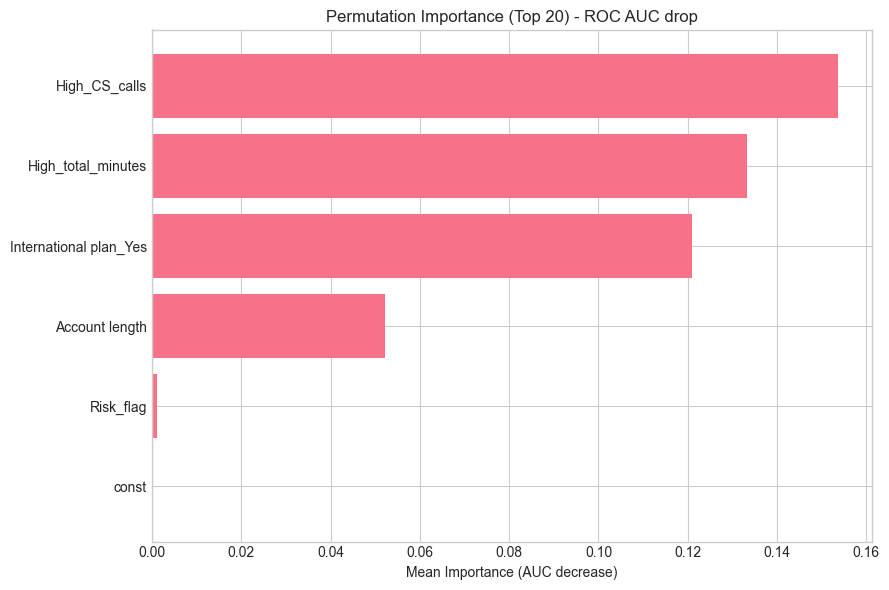

📊당초 유의미하다고 확인한 변수가 모두 상위권에 위치하는 것으로 보아 튜닝된 모델이 이 변수를 핵심으로 사용하고 있다고 판단할 수 있다.
➡️RandomForest 기준으로도 가설이 강하게 지지된다고 표현할 수 있다.


In [233]:
# 시각화 Permutation Importance Top20 Plot

top20 = perm_imp.head(20).sort_values('Importance_mean')

plt.figure(figsize=(9,6))
plt.barh(top20['Feature'], top20['Importance_mean'])
plt.title("Permutation Importance (Top 20) - ROC AUC drop")
plt.xlabel("Mean Importance (AUC decrease)")
plt.tight_layout()
plt.show()

print('📊당초 유의미하다고 확인한 변수가 모두 상위권에 위치하는 것으로 보아 튜닝된 모델이 이 변수를 핵심으로 사용하고 있다고 판단할 수 있다.')
print('➡️RandomForest 기준으로도 가설이 강하게 지지된다고 표현할 수 있다.')

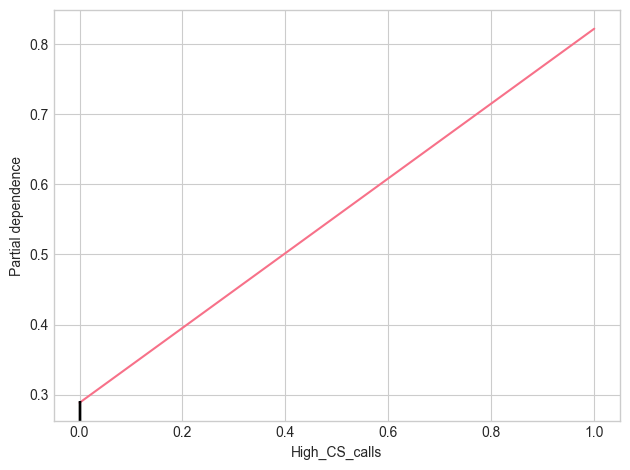

In [ ]:
# PDP(Partial Dependence Plot) 준비

X_sample = X.sample(n=min(1000, len(X)), random_state=42)

PartialDependenceDisplay.from_estimator(
    best_rf, X_sample,
    features=['High_CS_calls'],  
    kind='average'
)
plt.tight_layout()
plt.show()

(추가설명) 2. PDP(Partial Dependence Plot)
            : 고객서비스센터 통화수가 증가할 수록 이탈률이 증가하는가?
- x축 : High_CS_calls 
        0: 고객센터 통화 4회 미만
        1 : 고객센터 통화 4회 이상
- y축 : Partial dependence
        RandomFores가 예측하는 평균적인 이탈 확률의 변화
        다른 변수들은 평균적으로 고정해둔 상태에서 High_CS_calls만 바꿨을 때 영향력을 시각화 

📊 Partial Dependence Plot(PDP) 분석 결과, High_CS_calls(고객센터 통화 4회 이상 여부)는 고객 이탈 예측에 매우 강한 영향을 주는 변수로 확인되었다. High_CS_calls가 0인 경우 평균 예측 이탈 확률은 약 0.29 수준이었으나, High_CS_calls가 1인 경우 약 0.83 수준으로 크게 증가하였다. 이는 고객센터 통화가 잦은 고객군에서 이탈 위험이 급격히 증가한다는 가설을 RandomForest 모델 기반 분석에서도 지지하는 결과이다.

---
## **4. 모델평가**

### **모델 성능테스트**

**적용모델** : **RandomForest**
- churn-20 데이터로 최종 성능 평가  
- 훈련/검증 성능과 비교하여 일반화 성능 확인  
- 성능 하락이 크다면 overfitting 의심 및 재조정  

In [246]:
q75 = data80['Total_minutes'].quantile(0.75)
print("q75 기준:", q75)

test_df = data20.copy()
data20.columns = data20.columns.str.strip()

# 타겟 생성
if 'Churn_num' not in test_df.columns:
    if 'Churn' not in test_df.columns:
        raise KeyError("data20에 'Churn' 또는 'Churn_num'이 없습니다.")
    if test_df['Churn'].dtype == bool:
        test_df['Churn_num'] = test_df['Churn'].astype(int)
    else:
        s = test_df['Churn'].astype(str).str.strip().str.lower()
        test_df['Churn_num'] = s.isin(['yes','true','1']).astype(int)

# Total_minutes 생성
test_df['Total_minutes'] = (
    test_df['Total day minutes'] +
    test_df['Total eve minutes'] +
    test_df['Total night minutes'] +
    test_df['Total intl minutes']
)

# High_CS_calls 생성
test_df['High_CS_calls'] = (test_df['Customer service calls'] >= 4).astype(int)

# High_total_minutes 기준은 data80의 q75 사용
test_df['High_total_minutes'] = (test_df['Total_minutes'] >= q75).astype(int)

# Risk_flag 생성
test_df['Risk_flag'] = ((test_df['High_total_minutes']==1) & (test_df['High_CS_calls']==1)).astype(int)

test_df[['Total_minutes','High_total_minutes','High_CS_calls','Risk_flag','Churn_num']].head()

q75 기준: 653.0


,Total_minutes,High_total_minutes,High_CS_calls,Risk_flag,Churn_num
0,760.6,1,0,0,0
1,579.1,0,1,0,1
2,816.7,1,1,1,1
3,445.0,0,0,0,0
4,524.2,0,0,0,0


In [266]:
# 기존 모델 학습시 사용했던 X컬럼 구조 동일하게 적용

# data80
X_train = train_df.drop(columns=['Churn','Churn_num'], errors='ignore')
X_train = pd.get_dummies(X_train, drop_first=True)

train_cols = X_train.columns
len(train_cols)

#data20
X_test = test_df.drop(columns=['Churn','Churn_num'], errors='ignore')
X_test = pd.get_dummies(X_test, drop_first=True)

X_test = X_test.reindex(columns=train_cols, fill_value=0) 
#data20에 없는 컬럼은 0으로, data20에만 있는 컬럼은 제거

print(X_test.shape)

best_rf.fit(X_train, y_train)
print(X_train.shape, X_test.shape)


(667, 85)
(2666, 85) (667, 85)


In [265]:
# 최종예측 + 성능평가
y_test = test_df['Churn_num'].astype(int)

proba = best_rf.predict_proba(X_test)[:,1]
pred = (proba >= 0.5).astype(int)

print("📌 Final Test ROC-AUC:", roc_auc_score(y_test, proba))
print("\nConfusion Matrix")
print(confusion_matrix(y_test, pred))
print("\nClassification Report")
print(classification_report(y_test, pred, digits=4))

📌 Final Test ROC-AUC: 0.9146853146853147

Confusion Matrix
[[567   5]
 [ 53  42]]

Classification Report
              precision    recall  f1-score   support

           0     0.9145    0.9913    0.9513       572
           1     0.8936    0.4421    0.5915        95

    accuracy                         0.9130       667
   macro avg     0.9041    0.7167    0.7714       667
weighted avg     0.9115    0.9130    0.9001       667



In [268]:
threshold = 0.3
pred_03 = (proba >= threshold).astype(int)

print("Threshold =", threshold)
print(confusion_matrix(y_test, pred_03))
print(classification_report(y_test, pred_03, digits=4))

test_df.groupby('Risk_flag')['Churn_num'].mean() * 100

Threshold = 0.3
[[494  78]
 [ 12  83]]
              precision    recall  f1-score   support

           0     0.9763    0.8636    0.9165       572
           1     0.5155    0.8737    0.6484        95

    accuracy                         0.8651       667
   macro avg     0.7459    0.8687    0.7825       667
weighted avg     0.9107    0.8651    0.8783       667



Risk_flag
0    13.850837
1    40.000000
Name: Churn_num, dtype: float64

---
#### **최종 Test 성능 평가 결과 해석 **

**적용모델** : **RandomForest**
- churn-20 데이터로 최종 성능 평가  
- 훈련/검증 성능과 비교하여 일반화 성능 확인  
- 성능 하락이 크다면 overfitting 의심 및 재조정  

**1.최종 Test 성능 평가 결과 해석(Threshold=0.5)**  

**ROC-AUC**  
Final Test ROC-AUC = 0.9147
→ 매우 높은 분류 성능
→ 다른 통신사 데이터(data20)에서도 일반화 성능이 매우 우수함을 의미

**Confusion Matrix (threshold=0.5)**
이탈(1) 관점에서 중요한 지표
- Recall(이탈 탐지율) = 0.442
   실제 이탈자 95명 중 42명만 잡음
   이탈자를 절반 이상 놓치는 상태
- Precision(이탈 예측 정확도) = 0.894
   이탈이라고 예측한 사람 중 대부분이 진짜 이탈자
   “이탈 예측을 매우 보수적으로 하는 모델” 성향

   📌 결론:
threshold=0.5에서는 이탈자를 잘 놓치지만, 대신 잘못 경고(False Positive)는 거의 없음.

**2. Threshold 조정 결과 해석 (Threshold=0.3)**  
**Confusion Matrix (threshold=0.3)**  

이탈(1) 기준 성능 변화
- Recall: 0.8737 (87.4%)
   실제 이탈자 95명 중 83명을 잡음
   이탈 방지 관점에서는 매우 훌륭
- Precision: 0.5155
   이탈이라고 예측한 사람 중 절반 정도만 실제 이탈자
   즉, 경고 대상이 많이 늘어남

   📌 결론:
threshold=0.3으로 낮추면 이탈자를 거의 다 잡는 대신,
이탈이 아닌 사람도 위험군으로 많이 포함되는 trade-off가 생김.

**3. 가설 검증 핵심 결과: Risk_flag 이탈률 차이**  
     Risk_flag=0 → 13.85%  
     Risk_flag=1 → 40.00%  
  
즉, “통화량이 많은 고객 중 고객센터 통화 4회 이상인 고객(Risk_flag=1)”의 이탈률은
그렇지 않은 고객 대비 약 2.9배(40 / 13.85) 높다.

**[최종 결론]**  

 이탈 방지 목적에서는 Recall이 중요하므로 threshold를 0.3 수준으로 낮춰 위험 고객을 넓게 탐지하고, 이후 추가 규칙(예: 국제요금제 여부, CS_calls_group, 통화요금 상위구간)을 통해 타겟을 정제하는 방식이 효과적이다.

 본 분석에서는 “통화량이 많은 고객 중 고객서비스센터 통화횟수가 4회 이상인 경우 고객 이탈 확률이 높다”는 가설을 검증하기 위해 Random Forest 모델을 학습하고, 별도의 외부 통신사 데이터(data20)를 활용하여 최종 성능 평가를 수행하였다.
모델은 test 데이터에서 ROC-AUC 0.9147로 매우 높은 예측 성능을 보였으며, 이는 학습 데이터 외의 다른 통신사 데이터에서도 모델이 우수한 일반화 성능을 유지함을 의미한다. 또한 threshold를 0.5에서 0.3으로 조정할 경우 이탈자 탐지율(Recall)이 0.442에서 0.874로 크게 향상되어, 이탈 방지 캠페인 목적의 실무 적용 가능성이 높아졌다.
가설 검증 측면에서는 Risk_flag(고통화량 & 고객센터 통화 4회 이상) 집단의 이탈률이 40.0%로 나타났으며, 일반 집단(Risk_flag=0)의 이탈률 13.85% 대비 약 2.9배 높았다. 따라서 “통화량이 많은 고객 중 고객서비스센터 통화횟수가 4회 이상일 때 고객 이탈 위험이 높다”는 가설은 Random Forest 기반 분석과 외부 데이터 검증을 통해 강하게 지지된다.

---

#### 

Customer service calls    1.000000
Total night minutes       0.005236
Total intl minutes       -0.002826
Total eve minutes        -0.013192
Total day minutes        -0.024543
Name: Customer service calls, dtype: float64


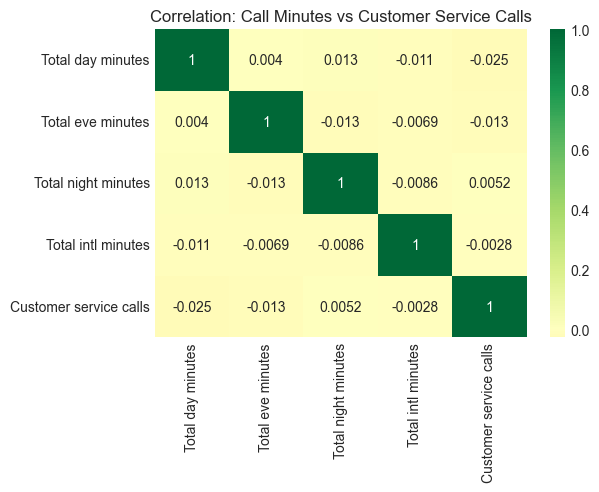

In [346]:
# Warming up _ Deep EDA 
# 통화량이 많은 고객과 고객센터 통화량과의 상관관계

call_cols = ['Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes']
target_col = 'Customer service calls'

print(data80[call_cols + [target_col]].corr()[target_col].sort_values(ascending=False))

cols = call_cols + ['Customer service calls']

plt.figure(figsize=(6,4))
sns.heatmap(data80[cols].corr(), annot=True, cmap='RdYlGn', center=0)
plt.title("Correlation: Call Minutes vs Customer Service Calls")
plt.show()

In [347]:
# Warming up _ Deep EDA 
# 통화량이 고객 이탈확률을 얼마나 올리는가?

X = data80[call_cols]
y = data80['Churn_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_s, y_train)

coef = pd.Series(model.coef_[0], index=call_cols).sort_values(ascending=False)
coef


Total day minutes      0.603706
Total intl minutes     0.294958
Total eve minutes      0.204047
Total night minutes    0.146505
dtype: float64

In [348]:
# Warming up _ Deep EDA 
# 통화량 -> 고객센터 호출 -> 이탈

call_cols = ['Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes']
cs_col = 'Customer service calls'
target = 'Churn_num'

X_base = data80[call_cols]                       # 통화량만
X_cs   = data80[[cs_col]]                        # 고객센터만
X_both = data80[call_cols + [cs_col]]            # 둘 다

y = data80[target]

# train/test split
X_train_b, X_test_b, y_train, y_test = train_test_split(
    X_base, y, test_size=0.25, random_state=42, stratify=y
)

X_train_cs, X_test_cs, _, _ = train_test_split(
    X_cs, y, test_size=0.25, random_state=42, stratify=y
)

X_train_both, X_test_both, _, _ = train_test_split(
    X_both, y, test_size=0.25, random_state=42, stratify=y
)

# scaling
scaler_b = StandardScaler()
X_train_b_s = scaler_b.fit_transform(X_train_b)
X_test_b_s  = scaler_b.transform(X_test_b)

scaler_cs = StandardScaler()
X_train_cs_s = scaler_cs.fit_transform(X_train_cs)
X_test_cs_s  = scaler_cs.transform(X_test_cs)

scaler_both = StandardScaler()
X_train_both_s = scaler_both.fit_transform(X_train_both)
X_test_both_s  = scaler_both.transform(X_test_both)

# 모델 학습
def fit_eval(Xtr, Xte, ytr, yte):
    model = LogisticRegression(max_iter=3000, random_state=42)
    model.fit(Xtr, ytr)
    proba = model.predict_proba(Xte)[:, 1]
    auc = roc_auc_score(yte, proba)
    return model, auc

model_A, auc_A = fit_eval(X_train_b_s, X_test_b_s, y_train, y_test)
model_B, auc_B = fit_eval(X_train_cs_s, X_test_cs_s, y_train, y_test)
model_C, auc_C = fit_eval(X_train_both_s, X_test_both_s, y_train, y_test)

print("* AUC 비교 *")
print("Model A (Call minutes only):", round(auc_A, 4))
print("Model B (CS calls only):", round(auc_B, 4))
print("Model C (Minutes + CS calls):", round(auc_C, 4))

coef_A = pd.Series(model_A.coef_[0], index=call_cols, name="ModelA_minutes_only")
coef_B = pd.Series(model_B.coef_[0], index=[cs_col], name="ModelB_cs_only")
coef_C = pd.Series(model_C.coef_[0], index=call_cols + [cs_col], name="ModelC_both")

coef_compare = pd.concat([coef_A, coef_C], axis=1)
display(coef_compare)


* AUC 비교 *
Model A (Call minutes only): 0.6356
Model B (CS calls only): 0.5621
Model C (Minutes + CS calls): 0.7063


,ModelA_minutes_only,ModelC_both
Total day minutes,0.603706,0.662926
Total eve minutes,0.204047,0.253573
Total night minutes,0.146505,0.168763
Total intl minutes,0.294958,0.316094
Customer service calls,NaN,0.625662


**결과 해석**:  
단순히 통화량이 많아 이탈하는 것이 아니라, 통화량이 많아 고객센터에 전화를 많이 하고 이것이 고객 이탈로 이어질 가능성이 큰 것으로 보여진다. 추가적으로 고객서비스센터 서비스 응대에 대한 점검이 필요한 것으로 보인다.

---

In [349]:
data80['CS_calls_group'] = pd.cut(
    data80['Customer service calls'],
    bins=[-1, 1, 3, 10],
    labels=['0-1', '2-3', '4+']
)

summary = data80.groupby('CS_calls_group').agg({
    'Total day minutes': 'mean',
    'Total eve minutes': 'mean',
    'Total night minutes': 'mean',
    'Total intl minutes': 'mean',
    'Churn_num': 'mean'
})

summary['Churn_rate(%)'] = summary['Churn_num'] * 100
summary

,Total day minutes,Total eve minutes,Total night minutes,Total intl minutes,Churn_num,Churn_rate(%)
CS_calls_group,,,,,,
0-1,181.216600,201.284200,200.455200,10.239800,0.118667,11.866667
2-3,177.534205,198.764226,202.627510,10.207741,0.103556,10.355649
4+,175.954286,201.355238,199.627143,10.350476,0.528571,52.857143


CS_calls_group,0-1,2-3,4+
Total_minutes_group,,,
Low,4.087193,3.750000,98.333333
Mid-Low,7.242340,7.335907,52.083333
Mid-High,7.792208,6.140351,20.370370
High,27.506427,24.890830,33.333333


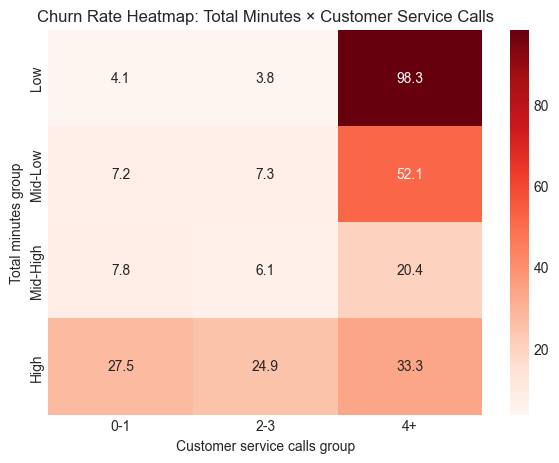

In [350]:
# 고객센터 호출을 고객 이탈 위험신호로 볼 수 있는지
# 고객센터 호출 4회 이상 이탈률 급증
# 통화량 상위 20% 이상 이탈률 급증
data80['Total_minutes'] = (
    data80['Total day minutes'] +
    data80['Total eve minutes'] +
    data80['Total night minutes'] +
    data80['Total intl minutes'])

data80['Total_minutes_group'] = pd.qcut(
    data80['Total_minutes'],
    q=4,
    labels=['Low', 'Mid-Low', 'Mid-High', 'High']
)

data80['CS_calls_group'] = pd.cut(
    data80['Customer service calls'],
    bins=[-1, 1, 3, 10],
    labels=['0-1', '2-3', '4+']
)

pivot1 = pd.pivot_table(
    data80,
    index='Total_minutes_group',
    columns='CS_calls_group',
    values='Churn_num',
    aggfunc='mean'
) * 100

display(pivot1)

plt.figure(figsize=(7,5))
sns.heatmap(pivot1, annot=True, fmt=".1f", cmap="Reds")
plt.title("Churn Rate Heatmap: Total Minutes × Customer Service Calls")
plt.ylabel("Total minutes group")
plt.xlabel("Customer service calls group")
plt.show()

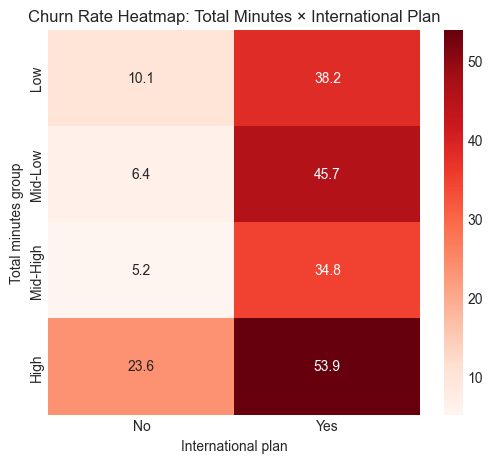

국제요금제 가입자의 이탈률이 높은 편이다.


In [351]:
pivot2 = pd.pivot_table(
    data80,
    index='Total_minutes_group',
    columns='International plan',
    values='Churn_num',
    aggfunc='mean'
) * 100

plt.figure(figsize=(6,5))
sns.heatmap(pivot2, annot=True, fmt=".1f", cmap="Reds")
plt.title("Churn Rate Heatmap: Total Minutes × International Plan")
plt.ylabel("Total minutes group")
plt.xlabel("International plan")
plt.show()

print('국제요금제 가입자의 이탈률이 높은 편이다.')

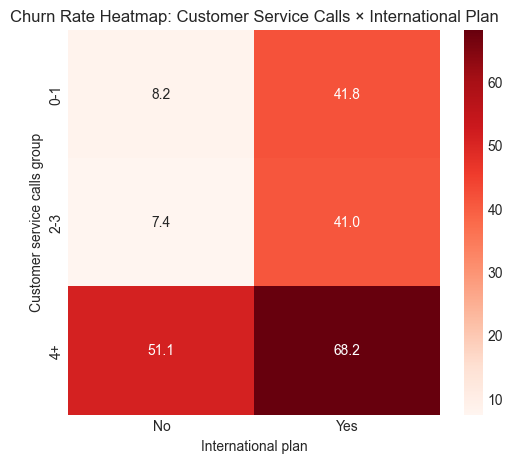

In [352]:
pivot3 = pd.pivot_table(
    data80,
    index='CS_calls_group',
    columns='International plan',
    values='Churn_num',
    aggfunc='mean'
) * 100

plt.figure(figsize=(6,5))
sns.heatmap(pivot3, annot=True, fmt=".1f", cmap="Reds")
plt.title("Churn Rate Heatmap: Customer Service Calls × International Plan")
plt.ylabel("Customer service calls group")
plt.xlabel("International plan")
plt.show()

**결과 해석**:  
고객센터에 호출이 많고(4회 이상), 국제요금제를 사용하는 고객은 이탈률이 높은 위험군에 포함될 확률이 높다.

In [353]:
# Warming up _ Deep EDA 
# 이탈고객 고위험군을 추정하는 파생변수 설정

data80['Risk_flag'] = (
    (data80['Total_minutes'] >= data80['Total_minutes'].quantile(0.75)) &
    (data80['International plan'] == 'Yes') &
    (data80['Customer service calls'] >= 4)
).astype(int)


In [354]:
# Warming up _ Deep EDA 
# State 별 이탈률과 고객 센터 호출 비교 : 지역간 서비스 품질 격차 여부 확인

state_summary = data80.groupby('State').agg(
    N=('Churn_num', 'size'),
    Churn_rate=('Churn_num', 'mean'),
    CS_calls_mean=('Customer service calls', 'mean'),
    CS_calls_median=('Customer service calls', 'median')
).reset_index()

# 퍼센트로 보기 좋게
state_summary['Churn_rate(%)'] = state_summary['Churn_rate'] * 100

# 정렬: 이탈률 높은 지역부터
state_summary = state_summary.sort_values('Churn_rate(%)', ascending=False)

state_summary.head(10)



,State,N,Churn_rate,CS_calls_mean,CS_calls_median,Churn_rate(%)
43,TX,55,0.290909,1.490909,1.0,29.090909
31,NJ,50,0.280000,1.700000,1.0,28.000000
2,AR,47,0.234043,2.148936,2.0,23.404255
20,MD,60,0.233333,1.650000,1.0,23.333333
25,MS,48,0.229167,1.687500,1.0,22.916667
40,SC,49,0.224490,1.469388,1.0,22.448980
21,ME,49,0.224490,1.734694,2.0,22.448980
22,MI,58,0.224138,1.586207,1.0,22.413793
38,PA,36,0.222222,1.305556,1.0,22.222222
33,NV,61,0.213115,1.606557,1.0,21.311475


In [355]:
state_summary[['Churn_rate(%)', 'CS_calls_mean']].corr(method='spearman')


,Churn_rate(%),CS_calls_mean
Churn_rate(%),1.00000,0.15143
CS_calls_mean,0.15143,1.00000


In [356]:
avg_churn = data80['Churn_num'].mean() * 100
avg_cs = data80['Customer service calls'].mean()

bad_states = state_summary[
    (state_summary['Churn_rate(%)'] >= avg_churn) &
    (state_summary['CS_calls_mean'] >= avg_cs)
].sort_values(['Churn_rate(%)', 'CS_calls_mean'], ascending=False)

bad_states.head(10)

,State,N,Churn_rate,CS_calls_mean,CS_calls_median,Churn_rate(%)
31,NJ,50,0.280000,1.700000,1.0,28.000000
2,AR,47,0.234043,2.148936,2.0,23.404255
20,MD,60,0.233333,1.650000,1.0,23.333333
25,MS,48,0.229167,1.687500,1.0,22.916667
21,ME,49,0.224490,1.734694,2.0,22.448980
22,MI,58,0.224138,1.586207,1.0,22.413793
33,NV,61,0.213115,1.606557,1.0,21.311475
30,NH,43,0.209302,1.627907,1.0,20.930233
26,MT,53,0.188679,1.584906,1.0,18.867925
34,NY,68,0.176471,1.691176,1.0,17.647059


In [357]:
state_summary['Quadrant'] = np.where(
    (state_summary['Churn_rate(%)'] >= avg_churn) & (state_summary['CS_calls_mean'] >= avg_cs),
    'High churn / High CS (Bad)',
    np.where(
        (state_summary['Churn_rate(%)'] >= avg_churn) & (state_summary['CS_calls_mean'] < avg_cs),
        'High churn / Low CS (Other causes)',
        np.where(
            (state_summary['Churn_rate(%)'] < avg_churn) & (state_summary['CS_calls_mean'] >= avg_cs),
            'Low churn / High CS (Complaints but retained)',
            'Low churn / Low CS (Good)'
        )
    )
)

state_summary['Quadrant'].value_counts()

Quadrant
Low churn / Low CS (Good)                        15
Low churn / High CS (Complaints but retained)    13
High churn / High CS (Bad)                       12
High churn / Low CS (Other causes)               11
Name: count, dtype: int64

#### 

---
**가설2**:  
State에 따라 고객 이탈률이 다른 이유는 해당 지역에 제공되는 네트워크 서비스의 품질이 낮기 때문이다. 

**분석 방법**  
: 변수 통제 - 지역(State) 자체의 영향만 분리해서 검증  

1. 모든 변수(통화량, 요금제, 고객센터 호출)를 동일하게 맞춘 상태에서도 특정 지역간 이탈률이 차이를 보이는 가 확인한다.
2. 로지스틱 회귀(Logistic Regression)에 통제변수(통화량, 고객센터, 요금제 등)를 넣고 State를 더미변수로 넣어, State 계수가 유의한지 확인한다.

**분석 이유**:  
- 지역별 이탈률이 높다고 해서 그 지역의 서비스가 나쁘다고 결론 지을 수 없다.  
- 지역별 고객 구성(요금제 가입여부, 통화량 정도, 고객센터 문의정도)가 다를 수 있기 때문에 해당 변수를 통제함으로써 State 별 서비스 영향도를 통계적으로 검증합니다.

In [269]:
df = data80.copy()
df.columns = df.columns.str.strip()

# Churn_num 생성
if 'Churn_num' not in df.columns:
    if df['Churn'].dtype == bool:
        df['Churn_num'] = df['Churn'].astype(int)
    else:
        s = df['Churn'].astype(str).str.strip().str.lower()
        df['Churn_num'] = s.isin(['yes','true','1']).astype(int)

df['Churn_num'].value_counts()

Churn_num
0    2278
1     388
Name: count, dtype: int64

In [273]:
# 기초 - State별 이탈률
state_churn = df.groupby('State')['Churn_num'].agg(['count','mean']).sort_values('mean', ascending=False)
state_churn['Churn_rate(%)'] = state_churn['mean']*100

display(state_churn.head(10))
state_churn.describe()

print('전체고객 중 이탈고객 비율인 14.5%와 비교하였을 때, 상위 10개의 지역의 경우, 상위하는 수치를 보이고 있다. ')
print('해당 기초자료로 State별 이탈률이 실제로 다르다는 현상을 파악할 수 있다.')
print('추가적으로 다른 변수의 영향을 제거하고 오직 state만 다를 때의 영향을 분석해볼 필요가 있다.')

,count,mean,Churn_rate(%)
State,,,
TX,55,0.290909,29.090909
NJ,50,0.280000,28.000000
AR,47,0.234043,23.404255
MD,60,0.233333,23.333333
MS,48,0.229167,22.916667
SC,49,0.224490,22.448980
ME,49,0.224490,22.448980
MI,58,0.224138,22.413793
PA,36,0.222222,22.222222


전체고객 중 이탈고객 비율인 14.5%와 비교하였을 때, 상위 10개의 지역의 경우, 상위하는 수치를 보이고 있다. 
해당 기초자료로 State별 이탈률이 실제로 다르다는 현상을 파악할 수 있다.
추가적으로 다른 변수의 영향을 제거하고 오직 state만 다를 때의 영향을 분석해볼 필요가 있다.


**중간분석**  
- 전체고객 중 이탈고객 비율인 14.5%와 비교하였을 때, 상위 10개의 지역의 경우, 상위하는 수치를 보이고 있다.   
- 해당 기초자료로 State별 이탈률이 실제로 다르다는 현상을 파악할 수 있다.   
- 추가적으로 다른 변수의 영향을 제거하고 오직 state만 다를 때의 영향을 분석해볼 필요가 있다.  

**분석방법**
1. State를 제외하고 통제변수만으로 이탈(Churn) 예측  
2. 그 예측값을 기준으로 '기대되는 이탈확률' 계산  
3. 실제 이탈이 기대보다 높게 나오는 지역(State)가 있는지 확인  
=> 즉, State 효과(설명되지 않는 부분)을 확인분석

In [335]:
df.columns = df.columns.str.strip()

if 'Churn_num' not in df.columns:
    if df['Churn_num'].dtype == bool:
        df['Churn'] = df['Churn'].astype(int)
    else:
        s = df['Churn'].astype(str).str.strip().str.lower()
        df['Churn_num'] = s.isin(['yes','true','1']).astype(int)

# State를 제외한 모델 (통제변수만 반영)

control_cols = [
    'Customer service calls',
    'International plan',
    'Voice mail plan',
    'Account length',
    'Total day minutes','Total eve minutes','Total night minutes','Total intl minutes'
]

# 필요한 컬럼만 추출
tmp = df[['Churn_num','State']+control_cols].copy()

# 결측제거
tmp = tmp.dropna()

# Yes/No -> 1/0 변환(가장 안전)
tmp['International plan'] = tmp['International plan'].astype(str).str.strip().str.lower().map({'yes':1, 'no':0})
tmp['Voice mail plan'] = tmp['Voice mail plan'].astype(str).str.strip().str.lower().map({'yes':1, 'no':0})

tmp = tmp.dropna()


# y, X 생성 (State 제외)
y = tmp['Churn_num'].astype(int)
X = tmp.drop(columns=['Churn_num', 'State'])

# 모든 컬럼을 숫자로 강제 변환
X = X.apply(pd.to_numeric, errors='coerce')
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# y도 X와 행 맞추기
y = y.loc[X.index]

# 상수항 추가
X = sm.add_constant(X)

# 모델 적합
control_model = sm.Logit(y, X).fit()

print(control_model.summary())

Optimization terminated successfully.
         Current function value: 0.328959
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Churn_num   No. Observations:                 2666
Model:                          Logit   Df Residuals:                     2657
Method:                           MLE   Df Model:                            8
Date:                Wed, 04 Feb 2026   Pseudo R-squ.:                  0.2071
Time:                        11:23:24   Log-Likelihood:                -877.00
converged:                       True   LL-Null:                       -1106.1
Covariance Type:            nonrobust   LLR p-value:                 6.553e-94
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -7.9295      0.579    -13.700      0.000      -9.064      

---
**[Logit Regression Results결과 분석]**  
  
🔹 종속변수 : Dep. Variable: Churn_num (이탈=1, 유지=0)  
🔹 모델 유의성  
      LLR p-value = 6.553e-94  
    → 거의 0에 가까움  
    → “이 모델은 통제변수들이 churn을 설명하는 데 의미가 있다”  

[통제변수의 Churn(고객이탈)에 주는 영향력]  
1. Customer service calls  
   coef = 0.5026, p<0.001 : 고객센터 호출 1회 증가할 때마다 Churn 증가
   Odds_ratio 변환 시 약 1.65  → 고객센터 호출이 1회 늘면 이탈 Odds가 약 1.65배 증가  

2. International plan  
    coef = 2.0740, p<0.001
    Odds_ratio = exp(2.074) ≈ 7.96 → 국제요금제 가입자의 경우, Odds가 약 8배 증가  

=> 국제요금제는 불만/가격민감/해지 가능성 높은 고객군일 수 있음을 추정할 수 있다. 

3. Voice mail plan  
   coef = -0.9092, p<0.001
   OR = exp(-0.909) ≈ 0.40  → 음성사서함 가입자는 churn odds가 약 60% 감소

4. Account length  
   coef = 0.0007, p=0.639 (유의X) → 가입기간은 통제변수 포함 시 churn에 유의하지 않음  

5. 통화량(분 단위)  
   Total day minutes: coef=0.0125 (유의)  
   Total eve minutes: coef=0.0055 (유의)  
   Total night minutes: coef=0.0026 (유의)  
   **Total intl minutes: coef=0.0960 (유의)**  
    → 전반적으로 통화량이 많을수록 churn 증가 (특히 국제 통화량 영향이 큼(0.096))


In [287]:
tmp['pred_proba_no_state'] = control_model.predict(X)
tmp['residual'] = tmp['Churn_num'] - tmp['pred_proba_no_state']

state_resid = tmp.groupby('State')['residual'].agg(['count','mean']).sort_values('mean', ascending=False)
state_resid.head(10)

,count,mean
State,,
TX,55,0.140428
SC,49,0.113082
NJ,50,0.090244
MT,53,0.089934
MS,48,0.073998
CA,24,0.071146
ME,49,0.070717
PA,36,0.069643
WA,48,0.069399


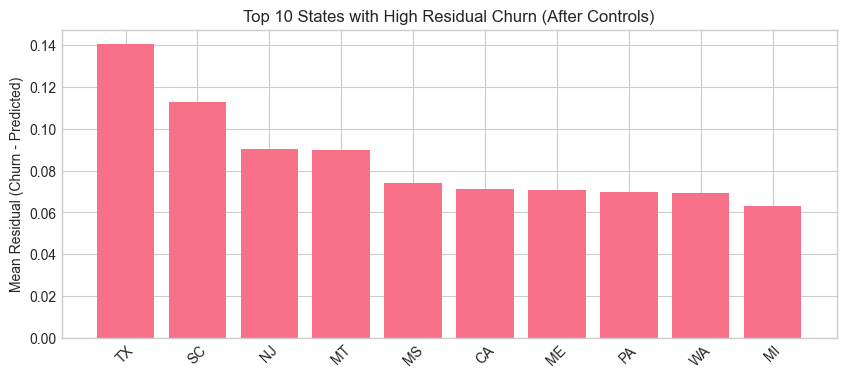

In [289]:
top10 = state_resid.head(10)

plt.figure(figsize=(10,4))
plt.bar(top10.index, top10['mean'])
plt.xticks(rotation=45)
plt.title("Top 10 States with High Residual Churn (After Controls)")
plt.ylabel("Mean Residual (Churn - Predicted)")
plt.show()

**[Top10 High Residual State]**  
: 다른 요인을 통제 후에도 특정 State에서 이탈이 더 많다!  

residual = 실제 Churn(0/1) − 예측 Churn 확률(통제변수 기반)  

residual 평균이 **양수(+)**면
→ 모델이 예상한 것보다 실제 이탈이 더 많이 발생
→ 통화량/요금제/CS calls로 설명되지 않는 추가 이탈 요인 존재  

**"TX 지표 0.140"** 
   :  “TX는 고객 특성(통화량, 요금제, CS calls)을 동일하게 통제했음에도 예상보다 평균 0.14(=14%p) 만큼 더 많이 이탈한다”  
    → 지역 자체의 영향이 존재한다는 강한 지표임

    => "고객 특성이 같다면, Churn은 비슷해야한다"는 전제를 세우고, 그럼에도 불구하고 특정 State(TX, SC, NJ, MT 등)에서 고객이탈(Churn)이 더 높게 나타난다면 **State 자체**의 영향(지역 서비스환경, 네트워크 품질, 경쟁 환경 등)이 존재한다고 해석 및 가설 설정가능
    => 다만, 현재 데이터만으로는 '지역별 네트워크 품질'이라고 확정짓기에는 추가적인 품질지표 등이 필요함  

**[다른 변수 통제 후 지역 효과 비교]**  
 통화량, 국제요금제 가입 여부, 고객센터 호출 횟수 등 고객 특성을 통제한 로지스틱 회귀 모델을 구축한 후, 해당 모델이 예측한 이탈 확률과 실제 이탈 여부의 차이(residual)를 State별로 비교하였다. 분석 결과 TX(0.140), SC(0.113), NJ(0.090), MT(0.090) 등 일부 지역은 통제변수를 고려한 상태에서도 예측보다 실제 이탈이 유의하게 높게 나타났다. 이는 단순한 고객 구성 차이만으로는 지역별 이탈률 격차가 설명되지 않으며, 특정 지역(State) 자체가 추가적인 이탈 요인으로 작용할 수 있음을 시사한다. 따라서 지역별 이탈률 차이는 지역 서비스 환경 또는 네트워크 품질 차이와 연관될 가능성이 있으며, 특히 residual이 높게 나타난 지역(TX, SC 등)은 네트워크 품질 점검 및 지역 단위 고객 유지 전략의 우선 대상이 될 수 있다.  

In [341]:
# 가설의 통계적 검정 : 고객 이탈에 있어 State 자체의 영향이 존재한다

df = data80.copy()
df.columns = df.columns.str.strip()

control_cols = [
    'Customer service calls',
    'International plan',
    'Voice mail plan',
    'Account length',
    'Total day minutes','Total eve minutes','Total night minutes','Total intl minutes'
]

# 1) 필요한 컬럼만 추출
tmp_state = df[['Churn_num','State'] + control_cols].dropna().copy()

# 2) Yes/No → 0/1
tmp_state['International plan'] = tmp_state['International plan'].astype(str).str.strip().str.lower().map({'yes':1,'no':0})
tmp_state['Voice mail plan'] = tmp_state['Voice mail plan'].astype(str).str.strip().str.lower().map({'yes':1,'no':0})
tmp_state = tmp_state.dropna()

# 3) State 더미 생성
tmp_state = pd.get_dummies(tmp_state, columns=['State'], drop_first=True)

# 확인(중요)
print("State 더미 개수:", sum(tmp_state.columns.str.startswith('State_')))
print(tmp_state.columns[:15])

State 더미 개수: 50
Index(['Churn_num', 'Customer service calls', 'International plan',
       'Voice mail plan', 'Account length', 'Total day minutes',
       'Total eve minutes', 'Total night minutes', 'Total intl minutes',
       'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT'],
      dtype='object')


In [342]:
y = tmp_state['Churn_num'].astype(int)
X = tmp_state.drop(columns=['Churn_num'])

# 숫자형 변환 + 결측 처리
X = X.apply(pd.to_numeric, errors='coerce')
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
X = X.astype(float)

X = sm.add_constant(X)

state_model = sm.Logit(y, X).fit()
print(state_model.summary())

Optimization terminated successfully.
         Current function value: 0.312309
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Churn_num   No. Observations:                 2666
Model:                          Logit   Df Residuals:                     2607
Method:                           MLE   Df Model:                           58
Date:                Wed, 04 Feb 2026   Pseudo R-squ.:                  0.2472
Time:                        11:33:31   Log-Likelihood:                -832.62
converged:                       True   LL-Null:                       -1106.1
Covariance Type:            nonrobust   LLR p-value:                 1.067e-80
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -9.0894      0.876    -10.377      0.000     -10.806      

In [343]:
state_table = pd.DataFrame({
    'coef': state_model.params,
    'odds_ratio': np.exp(state_model.params),
    'p_value': state_model.pvalues
})

state_effect = state_table[state_table.index.str.startswith('State_')].sort_values('p_value')

sig_state = state_effect[state_effect['p_value'] < 0.05]

print("유의한 State 개수:", len(sig_state))
sig_state.head(20)

유의한 State 개수: 3


,coef,odds_ratio,p_value
State_TX,1.829882,6.233148,0.011381
State_SC,1.869827,6.487174,0.012801
State_MT,1.679532,5.363047,0.023915


**[가설 검정]**   
: 통제변수(통화량/요금제/고객센터 통화량 등)을 동일하게 맞춘 상태에서도 State 자체가 유의한가?**  
**State 효과는 존재한다!**  
=> 특히 TX, SC, MT의 경우 다른 변수를 통제한 후에도 이탈 위험이 유의하게 높다.  

**[State 계수 유의성]**  
- p-value 해석 : 세 지역 모두 p-value < 0.05  
  => 통계적으로 유리함  
  => State 자체의 차이가 고객이탈에 유의한 영향을 준다.  

**[Odds_ratio 해석]**  
- TX: 6.23배 / SC: 6.49배 / MT: 5.36배  

통화량, 요금제(International/Voice mail), 고객센터 호출, 가입기간을 모두 통제했음에도 TX/SC/MT 지역 고객은 기준 지역 대비 이탈 odds가 5~6배 수준으로 높다.  
➡️ 이는 지역 서비스 환경 차이(네트워크 품질 문제 포함) 가 존재할 가능성을 매우 강하게 지지하는 것으로 볼 수 있다.  

**[결론]**  
 통화량(주간/야간/국제), 고객센터 호출 횟수, 국제요금제 및 음성사서함 가입 여부, 가입기간 등 주요 고객 특성을 통제한 로지스틱 회귀 분석을 수행한 결과, 일부 State 더미변수(TX, SC, MT)의 계수가 통계적으로 유의하였다(p<0.05). 특히 TX, SC, MT는 기준 State 대비 이탈 오즈가 각각 약 6.23배, 6.49배, 5.36배 높게 나타나, 고객 특성이 동일하더라도 지역(State) 자체가 이탈에 유의한 영향을 미칠 수 있음을 확인하였다. 따라서 State별 이탈률 차이는 단순한 고객 사용패턴 차이만으로 설명되지 않으며, 해당 지역의 네트워크 품질 또는 지역 서비스 환경 차이가 이탈에 영향을 줄 가능성이 높다. 이에 따라 TX, SC, MT 지역은 네트워크 품질 점검 및 지역 맞춤형 이탈 방지 전략의 우선 관리 대상으로 선정할 필요가 있다.

#### 

In [270]:
# Deep EDA
target = 'Churn_num'

control_cols = [
    'Customer service calls',
    'Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes',
    'International plan', 'Voice mail plan',
    'Account length'
]

df = data80[['State', target] + control_cols].copy()
df = df.dropna()
df[target] = df[target].astype(int)

X = df.drop(columns=[target])
y = df[target]

X = pd.get_dummies(X, drop_first=True)  # State 포함 자동 원핫인코딩
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

X = X.astype(float)        
X_sm = sm.add_constant(X)  # 절편 추가

logit_model = sm.Logit(y, X_sm)
result = logit_model.fit()

print(result.summary())

state_effect = result.params.filter(like='State_')
state_pvals = result.pvalues.filter(like='State_')

state_df = pd.DataFrame({
    'coef': state_effect,
    'p_value': state_pvals
}).sort_values('p_value')

state_df['odds_ratio'] = np.exp(state_df['coef'])
state_df.head(15)



Optimization terminated successfully.
         Current function value: 0.312309
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Churn_num   No. Observations:                 2666
Model:                          Logit   Df Residuals:                     2607
Method:                           MLE   Df Model:                           58
Date:                Wed, 04 Feb 2026   Pseudo R-squ.:                  0.2472
Time:                        08:43:50   Log-Likelihood:                -832.62
converged:                       True   LL-Null:                       -1106.1
Covariance Type:            nonrobust   LLR p-value:                 1.067e-80
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -9.0894      0.876    -10.377      0.000     -10.806      

,coef,p_value,odds_ratio
State_TX,1.829882,0.011381,6.233148
State_SC,1.869827,0.012801,6.487174
State_MT,1.679532,0.023915,5.363047
State_NJ,1.436382,0.050361,4.205453
State_MS,1.444051,0.057358,4.237829
State_WA,1.403960,0.063803,4.071291
State_ME,1.362413,0.067644,3.905604
State_MI,1.301467,0.075939,3.674682
State_PA,1.389845,0.078261,4.014226
State_NH,1.351227,0.080895,3.862162


**결과 해석**:  
- p_value < 0.05 인 세 지역(TX, SC, MT)의 경우, 통제변수 고려 후에도 이와 같은 값을 보이는 것으로 보아, 지역 서비스품질이 고객 이탈에 영향을 주는 것으로 추정할 수 있다. 

In [244]:
state_n = data80['State'].value_counts()

final_state_report = sig_states.copy()
final_state_report['N'] = final_state_report.index.str.replace('State_', '').map(state_n)

final_state_report = final_state_report.sort_values('odds_ratio', ascending=False)
final_state_report.head(20)

,coef,p_value,odds_ratio,N
State_SC,1.869827,0.012801,6.487174,49
State_TX,1.829882,0.011381,6.233148,55
State_MT,1.679532,0.023915,5.363047,53


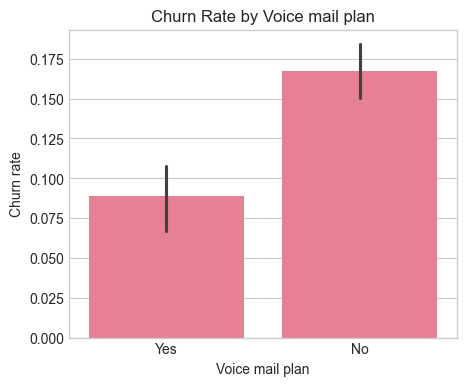

Voice mail plan 가입고객의 이탈률이 미가입 고객보다 낮다.


In [249]:
# Voice mail plan 가입여부와 고객 이탈 관계 분석

pd.crosstab(data80['Voice mail plan'], data80['Churn'], normalize='index') * 100

plt.figure(figsize=(5,4))
sns.barplot(data=data80, x='Voice mail plan', y='Churn_num')
plt.title("Churn Rate by Voice mail plan")
plt.ylabel("Churn rate")
plt.show()

print('Voice mail plan 가입고객의 이탈률이 미가입 고객보다 낮다.')

In [255]:
ct = pd.crosstab(data80['Voice mail plan'], data80['Churn_num'])
chi2, p, dof, expected = chi2_contingency(ct)

print("Chi-square:", chi2)
print("p-value:", p)

print('p-value < 0.05 의 결과로 미루어 Voice mail plan 서비스 가입여부에 따른 이탈률 차이가 의미가 있다.')

Chi-square: 25.65625337995575
p-value: 4.079713016862758e-07
p-value < 0.05 의 결과로 미루어 Voice mail plan 서비스 가입여부에 따른 이탈률 차이가 의미가 있다.


In [256]:
# Voice mail plan 가입여부와 다른 변수와의 관계 확인 

cols = [
    'Churn_num',
    'Voice mail plan',
    'Customer service calls',
    'Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes',
    'International plan',
    'Account length'
]

df = data80[cols].dropna().copy()

X = df.drop(columns=['Churn_num'])
y = df['Churn_num']

# 더미변수 처리
X = pd.get_dummies(X, drop_first=True)
X = X.astype(float)

X = sm.add_constant(X)
model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

# Voice mail plan 효과 분석 
voice_coef = result.params.filter(like='Voice mail plan')
voice_pval = result.pvalues.filter(like='Voice mail plan')

print("Voice mail plan coef:", voice_coef.values)
print("Voice mail plan p-value:", voice_pval.values)

print(f"🎯 coef < 0, p-value < 0.05 의 결과로 미루어보아, 다른 조건이 같아도 Voice mail plan 가입자의 이탈 가능성은 낮다.")

Optimization terminated successfully.
         Current function value: 0.328959
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Churn_num   No. Observations:                 2666
Model:                          Logit   Df Residuals:                     2657
Method:                           MLE   Df Model:                            8
Date:                Tue, 03 Feb 2026   Pseudo R-squ.:                  0.2071
Time:                        09:35:53   Log-Likelihood:                -877.00
converged:                       True   LL-Null:                       -1106.1
Covariance Type:            nonrobust   LLR p-value:                 6.553e-94
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -7.9295      0.579    -13.700      0.000      -9.064      

In [ ]:
# 위험군 타켓팅 분석 : 고객서비스센터에 문의가 많은 고객 중 Voice mail plan 가입자는 이탈률이 줄어들까?

pd.pivot_table(
    data80,
    index='Voice mail plan',
    columns='CS_calls_group',  # 이전에 만든 고객센터 그룹
    values='Churn_num',
    aggfunc='mean'
) * 100

CS_calls_group,0-1,2-3,4+
Voice mail plan,,,
No,14.085821,11.898017,56.774194
Yes,6.308411,6.000000,41.818182


**결과 해석**:  
- coef가 음수이고, p_value < 0.05 수준으로 **다른 조건이 같아도 Voice plan 가입자는 이탈 가능성이 낮다**는 것을 추정할 수 있다. 

[전략제안]  
1. 미가입자 중 위험군에게 Voice mail plan을 무료 또는 할인가격으로 제공한다.
2. 가입유도 프로모션 진행 : 혜택 안내, 가입절차 간소화, 첫달 무료 등 프로모션 진행


In [257]:
# Voice mail plan 가입자 vs 미가입자

num_cols = data80.select_dtypes(include='number').columns.tolist()
num_cols = [c for c in num_cols if c not in ['Churn_num']]  # 타겟 제외

vm_profile = data80.groupby('Voice mail plan')[num_cols].mean().T
vm_profile['diff(Yes-No)'] = vm_profile['Yes'] - vm_profile['No']

vm_profile.sort_values('diff(Yes-No)', ascending=False).head(15)

Voice mail plan,No,Yes,diff(Yes-No)
Number vmail messages,0.000000,29.175989,29.175989
Total_minutes,590.215727,594.063847,3.848120
Total eve minutes,199.785980,201.968895,2.182915
Total day minutes,179.033109,180.664393,1.631284
Area code,437.250905,437.934516,0.683610
Total night calls,99.938955,100.547067,0.608112
Total day charge,30.436151,30.713492,0.277341
Account length,100.560786,100.777626,0.216840
Total eve charge,16.982018,17.167708,0.185690
Total eve calls,99.981376,100.135061,0.153685


In [ ]:
# 국제요금제 가입자의 이탈률 비교 (voice mail plan 가입자 반영)
pd.crosstab(data80['Voice mail plan'], data80['International plan'], normalize='index') * 100

International plan,No,Yes
Voice mail plan,,
No,89.912054,10.087946
Yes,89.768076,10.231924


In [ ]:
# Voice mail plan 가입자와 미가입자의 이탈률 비교
data80.groupby('Voice mail plan')['Churn_num'].mean() * 100

Voice mail plan
No     16.709778
Yes     8.867667
Name: Churn_num, dtype: float64

In [262]:
# Voice mail plan 가입자 특성분석

df_vm = data80.copy()
df_vm['VM_num'] = (df_vm['Voice mail plan'] == 'Yes').astype(int)

features = [
    'Account length',
    'Customer service calls',
    'Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes',
    'International plan'
]

X = df_vm[features].copy()
X = pd.get_dummies(X, drop_first=True)
X = X.astype(float)
X = sm.add_constant(X)

y = df_vm['VM_num']

vm_model = sm.Logit(y, X).fit()
print(vm_model.summary())

Optimization terminated successfully.
         Current function value: 0.587509
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 VM_num   No. Observations:                 2666
Model:                          Logit   Df Residuals:                     2658
Method:                           MLE   Df Model:                            7
Date:                Tue, 03 Feb 2026   Pseudo R-squ.:                0.001030
Time:                        09:45:30   Log-Likelihood:                -1566.3
converged:                       True   LL-Null:                       -1567.9
Covariance Type:            nonrobust   LLR p-value:                    0.8631
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1.0859      0.352     -3.082      0.002      -1.777      

In [263]:
# Voice mail plan 제공시 기대되는 이탈 감소 효과 (uplift 추정)
# 통화량/고객센터/국제요금제 등 변수를 통제한 후, Voice mail plan이 이탈을 낮추는 지 효과 확인

# 로지스틱 회귀
cols = [
    'Churn_num',
    'Voice mail plan',
    'Customer service calls',
    'Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes',
    'International plan',
    'Account length'
]

df = data80[cols].dropna().copy()

X = pd.get_dummies(df.drop(columns=['Churn_num']), drop_first=True)
y = df['Churn_num']

X = X.astype(float)
X = sm.add_constant(X)

model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.328959
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Churn_num   No. Observations:                 2666
Model:                          Logit   Df Residuals:                     2657
Method:                           MLE   Df Model:                            8
Date:                Tue, 03 Feb 2026   Pseudo R-squ.:                  0.2071
Time:                        09:48:25   Log-Likelihood:                -877.00
converged:                       True   LL-Null:                       -1106.1
Covariance Type:            nonrobust   LLR p-value:                 6.553e-94
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -7.9295      0.579    -13.700      0.000      -9.064      

In [266]:
# 모든 고객에게 Voice mail plan 서비스 제공 vs 제공하지 않은 경우

X_yes = X.copy()
X_no = X.copy()

# Voice mail plan Yes 더미컬럼 이름 확인 필요
# 보통 'Voice mail plan_Yes' 로 생성됨
vm_col = [c for c in X.columns if 'Voice mail plan' in c][0]
print("Voice mail column:", vm_col)

# 가상 시나리오: 전원 가입
X_yes[vm_col] = 1

# 가상 시나리오: 전원 미가입
X_no[vm_col] = 0

# 예측 확률
p_yes = model.predict(X_yes)
p_no  = model.predict(X_no)

uplift_adjusted = (p_no.mean() - p_yes.mean())

print("조정된 Uplift(전체 평균 이탈률 감소 추정):", uplift_adjusted)

print('🎯Voice mail plan을 제공할 경우, 평균 이탈률이 약 8%p 감소할 것으로 추정된다!')

Voice mail column: Voice mail plan_Yes
조정된 Uplift(전체 평균 이탈률 감소 추정): 0.07967825135423667
🎯Voice mail plan을 제공할 경우, 평균 이탈률이 약 8%p 감소할 것으로 추정된다!


In [269]:
# 위험군에게 Voice mail plan 서비스 제공 vs 제공하지 않은 경우

high_risk = df[df['Customer service calls'] >= 4].copy() # 고객센터 통화횟수 4회 이상인 경우

X_hr = pd.get_dummies(high_risk.drop(columns=['Churn_num']), drop_first=True)
X_hr = X_hr.astype(float)
X_hr = sm.add_constant(X_hr)

# 컬럼 정렬 맞추기(중요!)
X_hr = X_hr.reindex(columns=X.columns, fill_value=0)

X_hr_yes = X_hr.copy()
X_hr_no  = X_hr.copy()

X_hr_yes[vm_col] = 1
X_hr_no[vm_col]  = 0

p_hr_yes = model.predict(X_hr_yes)
p_hr_no  = model.predict(X_hr_no)

uplift_hr = (p_hr_no.mean() - p_hr_yes.mean())

print("고위험군 uplift 추정:", uplift_hr)
print("고위험군 인원:", len(high_risk))

summary = pd.DataFrame({
    "Group": ["전체", "고객센터 4회 이상"],
    "N": [len(df), len(high_risk)],
    "Pred_Churn_if_VM_No": [p_no.mean(), p_hr_no.mean()],
    "Pred_Churn_if_VM_Yes": [p_yes.mean(), p_hr_yes.mean()],
    "Estimated_Uplift": [uplift_adjusted, uplift_hr]
})

summary

고위험군 uplift 추정: 0.15357713412573434
고위험군 인원: 210


,Group,N,Pred_Churn_if_VM_No,Pred_Churn_if_VM_Yes,Estimated_Uplift
0,전체,2666,0.167205,0.087527,0.079678
1,고객센터 4회 이상,210,0.386705,0.233128,0.153577


In [270]:
# 가입기간과 고객 이탈률 분석

data80[['Account length', 'Churn', 'Churn_num']].head()

,Account length,Churn,Churn_num
0,128,False,0
1,107,False,0
2,137,False,0
3,84,False,0
4,75,False,0


In [117]:
display(data80.groupby('Churn_num')['Account length'].agg(['count','mean','median','std']))
print('이탈자의 가입기간에 대한 mean/median 이 더 짧은 것을 확인할 수 있다.')

,count,mean,median,std
Churn_num,,,,
0,2278,100.330992,100.0,39.458936
1,388,102.319588,103.0,40.184599


이탈자의 가입기간에 대한 mean/median 이 더 짧은 것을 확인할 수 있다.


                count      mean  Churn_rate(%)
AcctLen_bin                                   
(0.999, 50.0]     278  0.133094      13.309353
(50.0, 67.0]      271  0.136531      13.653137
(67.0, 79.0]      253  0.158103      15.810277
(79.0, 91.0]      287  0.118467      11.846690
(91.0, 100.0]     252  0.158730      15.873016
(100.0, 111.0]    279  0.146953      14.695341
(111.0, 121.0]    251  0.167331      16.733068
(121.0, 134.0]    272  0.143382      14.338235
(134.0, 151.0]    260  0.130769      13.076923
(151.0, 243.0]    263  0.167300      16.730038


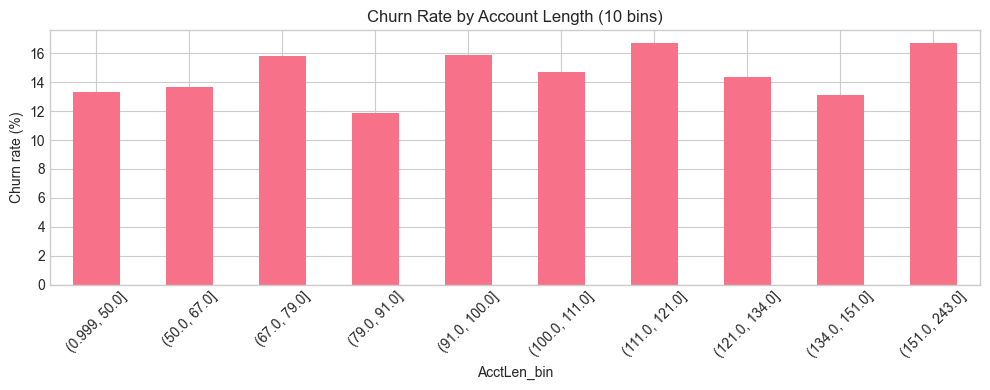

In [278]:
# 가입기간을 10개 구간으로 구분
data80['AcctLen_bin'] = pd.qcut(data80['Account length'], q=10)

# 구간별 이탈률 계산
acctlen_churn = data80.groupby('AcctLen_bin')['Churn_num'].agg(['count','mean'])
acctlen_churn['Churn_rate(%)'] = acctlen_churn['mean'] * 100
print(acctlen_churn)

plt.figure(figsize=(10,4))
acctlen_churn['Churn_rate(%)'].plot(kind='bar')
plt.title("Churn Rate by Account Length (10 bins)")
plt.ylabel("Churn rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [280]:
# 가입기간이 고객 이탈에 있어 유의미한 변수로 작용하는 지 여부에 대한 확인
stay = data80[data80['Churn_num']==0]['Account length']
churn = data80[data80['Churn_num']==1]['Account length']

t, p = stats.ttest_ind(stay, churn, equal_var=False)

print("t-stat:", t)
print("p-value:", p)

print('p-value > 0.05보다 훨씬 웃도는 수치로 고객이탈 분석에 통계적으로 유의미하지 않다.')

t-stat: -0.9034071077460794
p-value: 0.36672644666852583
p-value > 0.05보다 훨씬 웃도는 수치로 고객이탈 분석에 통계적으로 유의미하지 않다.
